In [221]:
%matplotlib inline

import os

import matplotlib
import numpy as np
import pylab as pl
import pandas as pd
from scipy import optimize
import matplotlib.pyplot as plt
from astropy.time import Time
from astropy.table import Table
import seaborn as sns

import corner

import radvel
import radvel.likelihood
from radvel.plot import orbit_plots, mcmc_plots
import random 
from matplotlib import ticker
from astropy.timeseries import LombScargle
from Constants import Constants

c=Constants()

matplotlib.rcParams['font.size'] = 9
plt.rcParams['font.family'] = 'stixgeneral'
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.size'] = 11
plt.rcParams['figure.facecolor'] = 'white'
#plt.rcParams['legend.handletextpad']=-0.5

Constants defined...


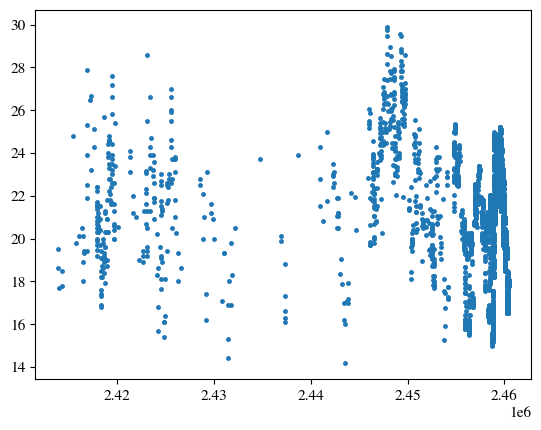

['JD', 'Magnitude', 'Uncertainty', 'HQuncertainty', 'Band', 'Observer Code', 'Comment Code(s)', 'Comp Star 1', 'Comp Star 2', 'Charts', 'Comments', 'Transfomed', 'Airmass', 'Validation Flag', 'Cmag', 'Kmag', 'HJD', 'Star Name', 'Observer Affiliation', 'Measurement Method', 'Grouping Method', 'ADS Reference', 'Digitizer', 'Credit']
chi2/dof =  0.8914220626314039


Text(0, 0.5, 'mag, flattened')

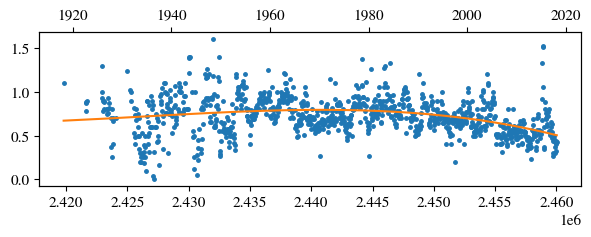

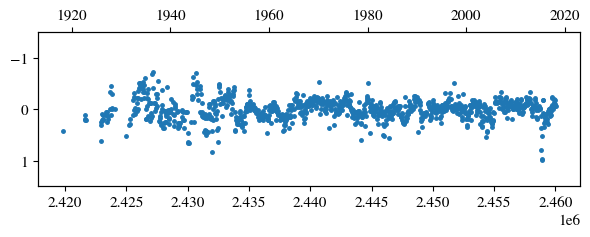

In [222]:
## RVs
rva = Table.read('RVs/BG_rvall.csv')
plt.plot(rva['JD'],rva['RV'],'.')
plt.show()

# Photometry
daavso = Table.read("aavsodata_643217704ea90.txt",format='ascii') # new AAVSO file
# removed a few measurements that had photometry given as <1.6 
daavso.sort('JD')
print(daavso.keys())
daavso['Magnitude']=daavso['Magnitude'].astype(float)

selVisV = (daavso['Band']=='Vis.') | (daavso['Band']=='V') 
selVis  = (daavso['Band']=='Vis.')
selV  = (daavso['Band']=='V')
selJ  = (daavso['Band']=='J')
selH  = (daavso['Band']=='H')
seldate = daavso['JD']<2458000



from astropy.modeling import models, fitting


def get_rolling_means(t,rv,dt):
    """time (JD), rv (km/s), dt (days)"""

    bins = np.linspace(t[0],t[-1],int(np.ceil((t[-1]-t[0])/dt)) )
    xpm = (bins[1:]+bins[:-1])/2
    ypm = np.zeros_like(xpm)
    epm = np.zeros_like(xpm)

    for i in range(len(bins)-1):
        sel = (t >= bins[i]) & (t < bins[i+1])
        #print(bins[i],bins[i+1],len(rv[sel]), np.nanmean(rv[sel]), np.sqrt( np.var(rv[sel]) ) )
        ypm[i] = np.nanmean(rv[sel])
        epm[i] = np.sqrt( np.var(rv[sel]) )

    sel = np.isfinite(ypm)
    return xpm[sel],ypm[sel],epm[sel]

# 12 = 1 month rolling means
npyr =12
#seldate2 = (daavso['JD']>Time(1950,format='jyear').jd ) & (daavso['JD']<Time(1990,format='jyear').jd )
mysel = selVis  #& seldate #selVis & seldate
_t,_mag,_emag = get_rolling_means(daavso[mysel]['JD'],daavso[mysel]['Magnitude'],365.25/npyr)
aavsoT = Table([_t,_mag,_emag],names=['JD','mag','mag_err'])


fig,ax = plt.subplots(figsize=(7,2))
ax.plot(aavsoT['JD'],aavsoT['mag'],'.')

ayr = ax.twiny()
ayr.set_xlim(Time(aavsoT['JD'][0],format='jd').jyear, Time(aavsoT['JD'][-1],format='jd').jyear)



m_init = models.Polynomial1D(3)
fit_m = fitting.LevMarLSQFitter()
m = fit_m(m_init, aavsoT['JD'],aavsoT['mag'] )

ax.plot(aavsoT['JD'],m(aavsoT['JD']) )

print('chi2/dof = ',np.sum(  (aavsoT['mag']-m(aavsoT['JD']))**2 )  / np.std(aavsoT['mag'])**2  / (len(aavsoT)-len(m_init.parameters)))\


aavsoT['mag_flat'] = aavsoT['mag']-m(aavsoT['JD'])

fig,ax = plt.subplots(figsize=(7,2))
ax.plot(aavsoT['JD'],aavsoT['mag_flat'],'.')
ax.set_ylim(1.5,-1.5)

ayr = ax.twiny()
ayr.set_xlim(Time(aavsoT['JD'][0],format='jd').jyear, Time(aavsoT['JD'][-1],format='jd').jyear)
plt.ylabel('mag, flattened')

# Summary Figure

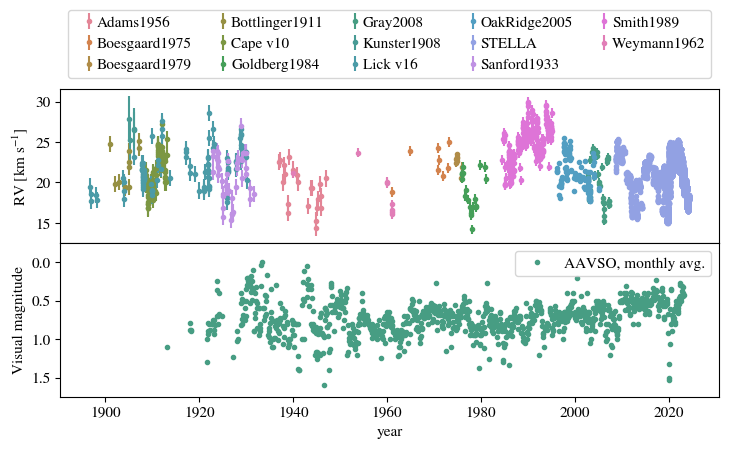

In [223]:
fig,axs = plt.subplots(figsize=(8.5,4),nrows=2,ncols=1,sharex=True)

colors=sns.color_palette("husl",n_colors=len(np.unique(rva['source'])),desat=0.7 )
for i,source in enumerate(np.unique(rva['source'])):
    sel = rva['source']==source
    axs[0].errorbar(Time(rva['JD'][sel],format='jd').jyear,rva['RV'][sel],rva['RV_err'][sel],
                 label=source,marker='o',linestyle='',color=colors[i],markersize=3,rasterized=True)
axs[0].legend(bbox_to_anchor=(0, 1.02,1,0.2),loc='lower left',mode='expand',ncols=5,handletextpad=-0.5)
axs[0].set_ylabel('RV [km s$^{-1}$]')

axs[1].plot(Time(aavsoT['JD'],format='jd').jyear,aavsoT['mag'],
                marker='o',linestyle='',markersize=3,label='AAVSO, monthly avg.',color=colors[6],rasterized=True)
axs[1].legend(loc='upper right')
axs[1].set_ylim(1.75,-0.25)
axs[1].set_ylabel('Visual magnitude')
axs[1].set_xlabel('year')

plt.subplots_adjust(hspace=0)

plt.savefig("figs/rv_aavso_summary.pdf",bbox_inches='tight',dpi=300)

# Periodogram

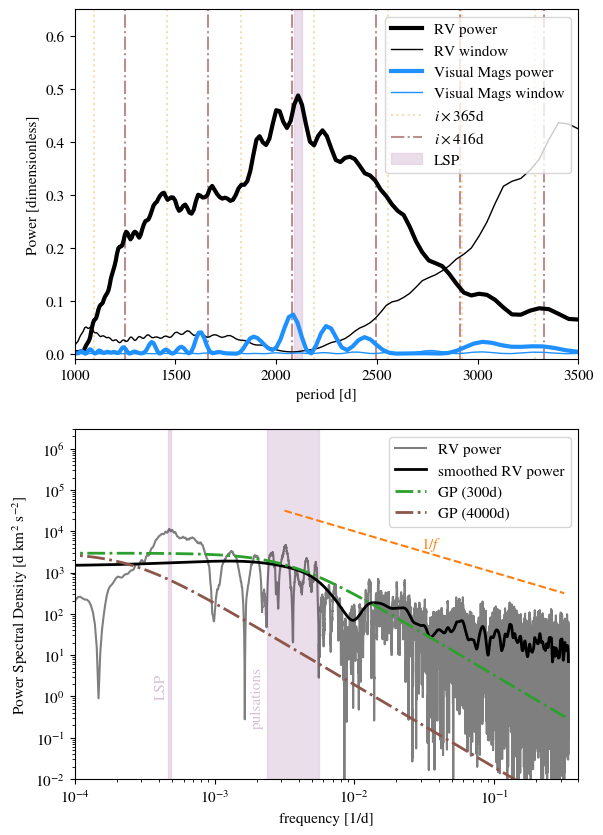

In [263]:



window_fr, window = LombScargle(rva['JD'], np.ones_like(rva['RV'])).autopower()
fr, power = LombScargle(rva['JD'], rva['RV']).autopower()
a_fr, a_pow = LombScargle(aavsoT['JD'],aavsoT['mag']).autopower()
a_wfr,a_wpow = LombScargle(aavsoT['JD'],np.ones_like(aavsoT['mag'])).autopower()


plt.figure(figsize=(6.5,10))
plt.subplot(211)
plt.plot(1/fr,power,label='RV power',ls='-',lw=3,color='k')
plt.plot(1/window_fr,window,label='RV window',lw=1,color='k')
plt.plot(1/a_fr,a_pow,label='Visual Mags power',ls='-',lw=3,color='dodgerblue')
plt.plot(1/a_wfr,a_wpow,label='Visual Mags window',ls='-',lw=1,color='dodgerblue')


for i in range(10):
    plt.axvline(i*365,color='wheat',label=np.where(i==0,r'$i\times365$d',''),zorder=0,ls=':')
    plt.axvline(i*416,color='RosyBrown',label=np.where(i==0,r'$i\times416$d',''),zorder=0,ls='-.')

plt.axvspan(2090,2130,alpha=0.5,color='thistle',label='LSP')


#plt.semilogx()
plt.xlim(1000,3500)
plt.ylim(-0.01,0.65)
plt.legend(loc='upper right')
plt.xlabel('period [d]')
plt.ylabel('Power [dimensionless]')




from astropy.convolution import Gaussian1DKernel, convolve

plt.subplot(212)

def Sexp(f,l=3000):
    """ f is in [1/d], ref: p28: https://gpss.cc/gpss21/slides/Heinonen2021.pdf,
     Wolfram Alpha: "Fourier transform exp(- |x|/l)" (normalization 1)  """ 
    return 2*l/(1+(l*f)**2)  #((1/l + l*f**2  ))**-1


rv = Table.read("RVs/BG_rvall.csv")
fr, power = LombScargle(rv["JD"], rv['RV'],normalization='psd').autopower(method='auto')



plt.loglog(fr,power,label='RV power',ls='-',alpha=0.5,color='k')
plt.loglog(fr,convolve(power,Gaussian1DKernel(300)),label='smoothed RV power',ls='-',lw=2,color='k')
plt.xlabel('frequency [1/d]')
plt.ylabel('Power Spectral Density [d km$^2$ s$^{-2}$]')

xp = np.logspace(-2.5,-0.5,100)
plt.plot(xp,1e2/xp,ls='--',color='C1')

plt.axvspan(1/2150,1/2050,alpha=0.5,color='thistle')
plt.axvspan(1/420,1/180,alpha=0.5,color='thistle')
plt.annotate("LSP",(1/2700,1),rotation=90,color='thistle')
plt.annotate("pulsations",(1/550,0.2),rotation=90,color='thistle')
plt.annotate("$1/f$",(0.03,4e3),color='C1')

plt.plot(fr,2.22**2 * Sexp(fr,l=300),ls='-.',label='GP (300d)',lw=2,color='C2')
plt.plot(fr,0.62**2 * Sexp(fr,l=4000),ls='-.',label='GP (4000d)',lw=2,color='C5')

plt.xlim(1e-4,0.4)
plt.ylim(1e-2,3e6)
plt.legend(loc="upper right")


plt.savefig("figs/power_spec.pdf",bbox_inches='tight',dpi=300)

In [225]:
Time( rv['JD'][[0,-1]], format='jd').iso

array(['1896-10-03 13:12:00.000', '2024-05-07 20:08:40.272'], dtype='<U23')

In [226]:
np.max( np.gradient(rv['JD'])) , np.min( np.gradient(rv['JD'])) 

(2384.25, 4.998873919248581e-07)

# RADVEL ANALYSIS

240000
795 data points


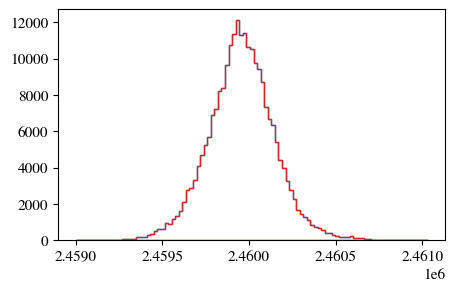

2023.025746051453
per1 : 2110.2 +/- 8.6
tc1 : 2459955 +/- 180
secosw1 : 0.1 +/- 0.25
sesinw1 : -0.27 +/- 0.37
logk1 : 7.3 +/- 0.23
gamma : 21260 +/- 290
jit : 19 +/- 11
gp_length : 300 +/- 1
gp_amp : 2218 +/- 67


In [227]:
gppost = radvel.posterior.load("radvel/BG_radvel_MLE_Exp300.0_rv10_p2000.0_2200.0_e0.6___iter_0.pkl")
gpchains = gppost.chains
gplike = gppost.likelihood
print( len(gpchains) )

vfactor=1e3


print(gplike.N,"data points")


# FOLD TC1
tc1med = gpchains['tc1'].quantile(0.5)
sel_p1 = np.abs(gpchains['tc1'] - tc1med) > np.abs(gpchains['tc1'] - gpchains['per1'] - tc1med)
sel_m1 = np.abs(gpchains['tc1'] - tc1med) > np.abs(gpchains['tc1'] + gpchains['per1'] - tc1med)


gpchains.loc[:,'tc1_fold'] = gpchains['tc1'].loc[:]
gpchains.loc[sel_p1,'tc1_fold'] = gpchains['tc1'].loc[sel_p1]-gpchains['per1'].loc[sel_p1]
gpchains.loc[sel_m1,'tc1_fold'] = gpchains['tc1'].loc[sel_m1]+gpchains['per1'].loc[sel_m1]


plt.figure(figsize=(5,3))
mybins = np.linspace(2459000,2459032.625+2000, 100)
plt.hist(gpchains['tc1'],histtype='step',bins=mybins,density=False)

plt.hist(gpchains['tc1'][sel_p1],histtype='step',bins=mybins,density=False)
plt.hist(gpchains['tc1'][sel_m1],histtype='step',bins=mybins,density=False)

plt.hist(gpchains['tc1_fold'],histtype='step',bins=mybins,density=False)

plt.show()

# write over tc1
gpchains.tc1.loc[:] = gpchains.tc1_fold.loc[:]
# drop column
gpchains.drop(['tc1_fold'],axis=1)
 
print(np.mean(Time(gpchains['tc1'],format='jd').jyear) )






quants = gpchains.quantile([0.159, 0.5, 0.841]) # median & 1sigma limits of posterior distributions

for par in gppost.params.keys():
    if gppost.params[par].vary:
        med = quants[par][0.5]
        high = quants[par][0.841] - med
        low = med - quants[par][0.159]
        err = np.mean([high,low])
        err = radvel.utils.round_sig(err)
        med, err, errhigh = radvel.utils.sigfig(med, err)
        print('{} : {} +/- {}'.format(par, med, err))
        
        
#df_synth = gppost.params.basis.to_synth(gpchains)
labels = 'per1 tc1 logk1 gamma'.split()
#gpchains[labels].quantile([0.01,0.05,0.14,0.5,0.84,0.95,0.99]).T

In [228]:
gppost.params

Parameters([('per1',
             Parameter object: value = 2113.2624282538063, vary = True, mcmc scale = 10),
            ('tc1',
             Parameter object: value = 2459952.4474509372, vary = True, mcmc scale = 30),
            ('secosw1',
             Parameter object: value = 0.13121238582612726, vary = True, mcmc scale = None),
            ('sesinw1',
             Parameter object: value = -0.7073555940852442, vary = True, mcmc scale = None),
            ('logk1',
             Parameter object: value = 7.42520542966518, vary = True, mcmc scale = None),
            ('gamma',
             Parameter object: value = 21240.435504168443, vary = True, mcmc scale = None),
            ('jit',
             Parameter object: value = 10.006299589641467, vary = True, mcmc scale = None),
            ('dvdt',
             Parameter object: value = 0.0, vary = False, mcmc scale = None),
            ('curv',
             Parameter object: value = 0.0, vary = False, mcmc scale = None),
         

In [229]:
gppost.priors

[Gaussian prior on gamma, mu=21100.0, sigma=3000.0,
 Bounded prior on per1, min=2000.0, max=2200.0,
 Bounded prior on tc1, min=2458445, max=2461445,
 Jeffrey's prior on jit, min=10.0, max=3000.0,
 Bounded prior on logk1, min=4.605170185988091, max=9.210340371976182,
 e1 constrained to be < 0.6,
 Jeffrey's prior on gp_amp, min=10.0, max=20000.0,
 Gaussian prior on gp_length, mu=300.0, sigma=1]

In [230]:
Time(2458445,format='jd').jyear , Time(2461445,format='jd').jyear


(2018.8911704312115, 2027.1047227926078)

Corner plot saved to figs/corner_mcmc_full.pdf


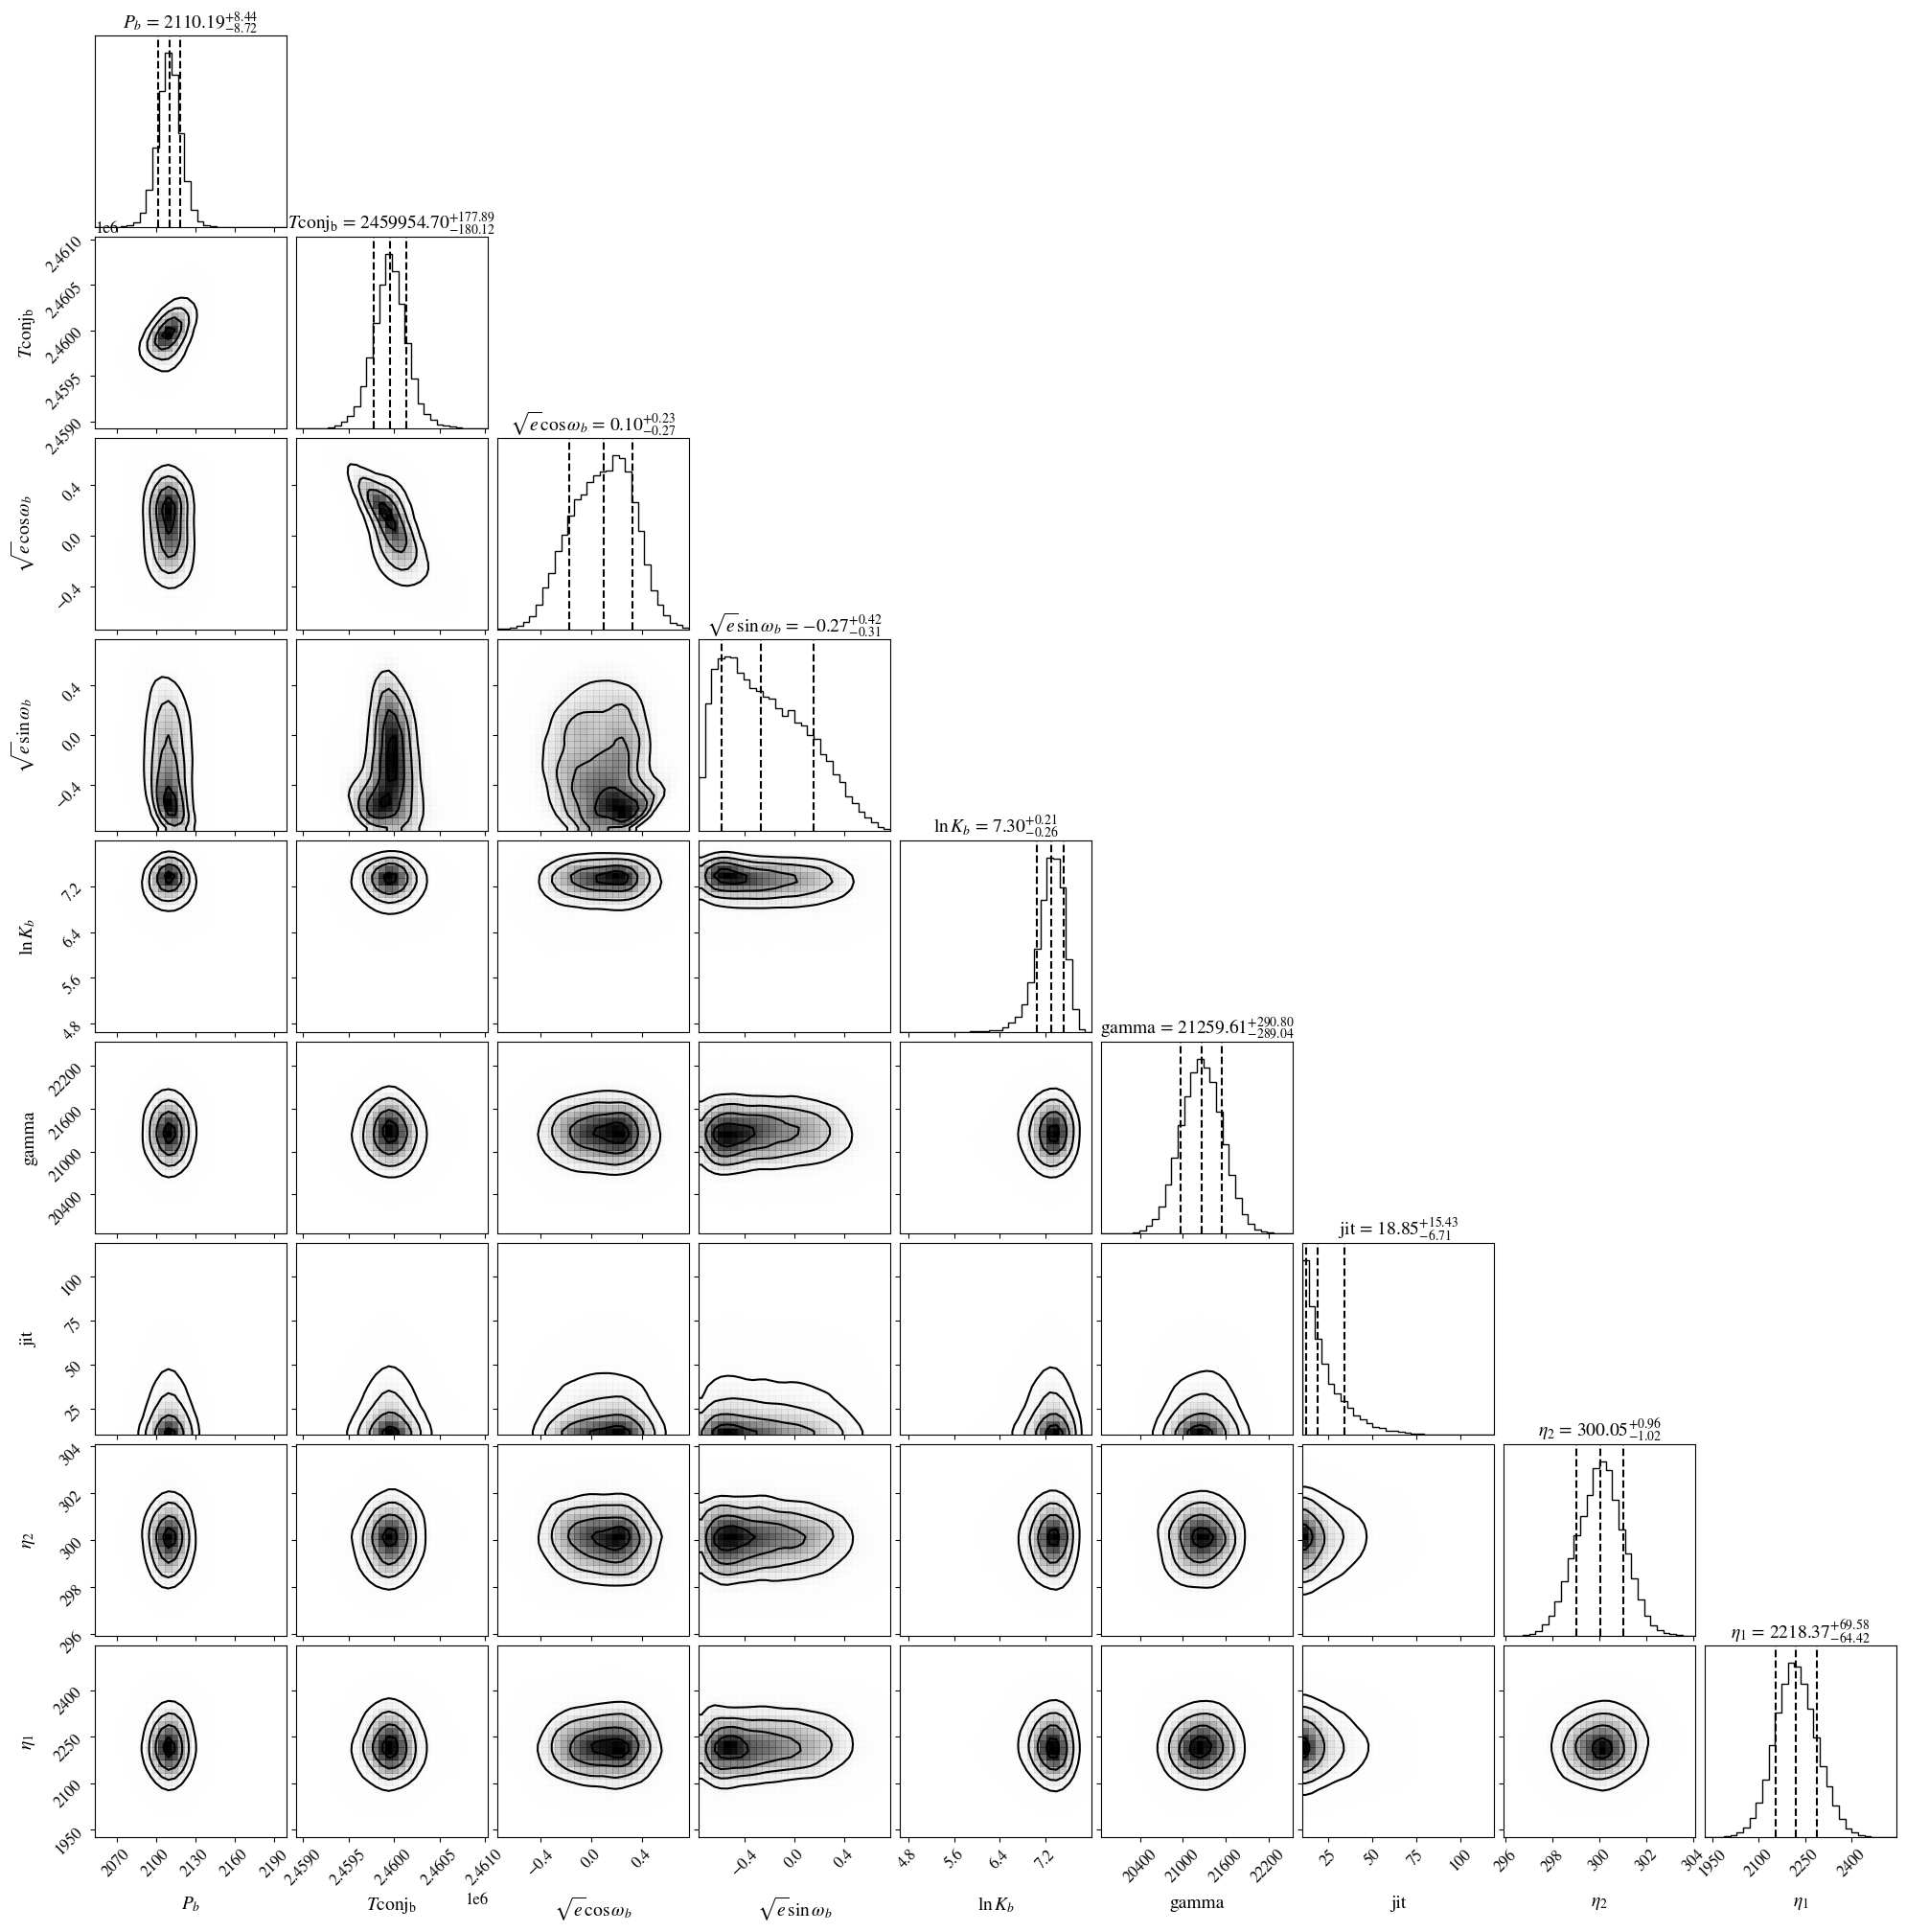

In [231]:
Corner = mcmc_plots.CornerPlot(gppost, gpchains)
Corner.saveplot = "figs/corner_mcmc_full.pdf"
Corner.plot()

# Radvel Circular 



216000
795 data points


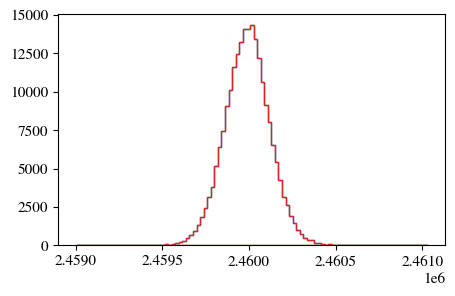

2023.11816490388
per1 : 2109.2 +/- 9.2
tc1 : 2459989 +/- 130
logk1 : 7.3 +/- 0.23
gamma : 21272 +/- 290
jit : 19 +/- 11
gp_length : 300.0 +/- 0.99
gp_amp : 2222 +/- 66


In [232]:
gppost = radvel.posterior.load("radvel/BG_radvel_MLE_Exp300.0_rv10_p2000.0_2200.0_circ___iter_0.pkl")
gpchains = gppost.chains
gplike = gppost.likelihood
print( len(gpchains) )

gpchains['secosw1'] = 0.
gpchains['sesinw1'] = 0.


vfactor=1e3


print(gplike.N,"data points")


# FOLD TC1
tc1med = gpchains['tc1'].quantile(0.5)
sel_p1 = np.abs(gpchains['tc1'] - tc1med) > np.abs(gpchains['tc1'] - gpchains['per1'] - tc1med)
sel_m1 = np.abs(gpchains['tc1'] - tc1med) > np.abs(gpchains['tc1'] + gpchains['per1'] - tc1med)


gpchains.loc[:,'tc1_fold'] = gpchains['tc1'].loc[:]
gpchains.loc[sel_p1,'tc1_fold'] = gpchains['tc1'].loc[sel_p1]-gpchains['per1'].loc[sel_p1]
gpchains.loc[sel_m1,'tc1_fold'] = gpchains['tc1'].loc[sel_m1]+gpchains['per1'].loc[sel_m1]


plt.figure(figsize=(5,3))
mybins = np.linspace(2459000,2459032.625+2000, 100)
plt.hist(gpchains['tc1'],histtype='step',bins=mybins,density=False)

plt.hist(gpchains['tc1'][sel_p1],histtype='step',bins=mybins,density=False)
plt.hist(gpchains['tc1'][sel_m1],histtype='step',bins=mybins,density=False)

plt.hist(gpchains['tc1_fold'],histtype='step',bins=mybins,density=False)

plt.show()

# write over tc1
gpchains.tc1.loc[:] = gpchains.tc1_fold.loc[:]
# drop column
gpchains.drop(['tc1_fold'],axis=1)
 
print(np.mean(Time(gpchains['tc1'],format='jd').jyear) )






quants = gpchains.quantile([0.159, 0.5, 0.841]) # median & 1sigma limits of posterior distributions

for par in gppost.params.keys():
    if gppost.params[par].vary:
        med = quants[par][0.5]
        high = quants[par][0.841] - med
        low = med - quants[par][0.159]
        err = np.mean([high,low])
        err = radvel.utils.round_sig(err)
        med, err, errhigh = radvel.utils.sigfig(med, err)
        print('{} : {} +/- {}'.format(par, med, err))
        
        
#df_synth = gppost.params.basis.to_synth(gpchains)
labels = 'per1 tc1 logk1 gamma'.split()
#gpchains[labels].quantile([0.01,0.05,0.14,0.5,0.84,0.95,0.99]).T

In [233]:
gppost.params

Parameters([('per1',
             Parameter object: value = 2108.720961304522, vary = True, mcmc scale = 10),
            ('tc1',
             Parameter object: value = 2459983.9780579736, vary = True, mcmc scale = 30),
            ('secosw1',
             Parameter object: value = 0.0, vary = False, mcmc scale = None),
            ('sesinw1',
             Parameter object: value = 0.0, vary = False, mcmc scale = None),
            ('logk1',
             Parameter object: value = 7.397771744012378, vary = True, mcmc scale = None),
            ('gamma',
             Parameter object: value = 21275.74714680594, vary = True, mcmc scale = None),
            ('jit',
             Parameter object: value = 10.000000106921167, vary = True, mcmc scale = None),
            ('dvdt',
             Parameter object: value = 0.0, vary = False, mcmc scale = None),
            ('curv',
             Parameter object: value = 0.0, vary = False, mcmc scale = None),
            ('gp_length',
             P

In [234]:
gppost.priors

[Gaussian prior on gamma, mu=21100.0, sigma=3000.0,
 Bounded prior on per1, min=2000.0, max=2200.0,
 Bounded prior on tc1, min=2458445, max=2461445,
 Jeffrey's prior on jit, min=10.0, max=3000.0,
 Bounded prior on logk1, min=4.605170185988091, max=9.210340371976182,
 Jeffrey's prior on gp_amp, min=10.0, max=20000.0,
 Gaussian prior on gp_length, mu=300.0, sigma=1]

Corner plot saved to figs/corner_mcmc_full_circ.pdf


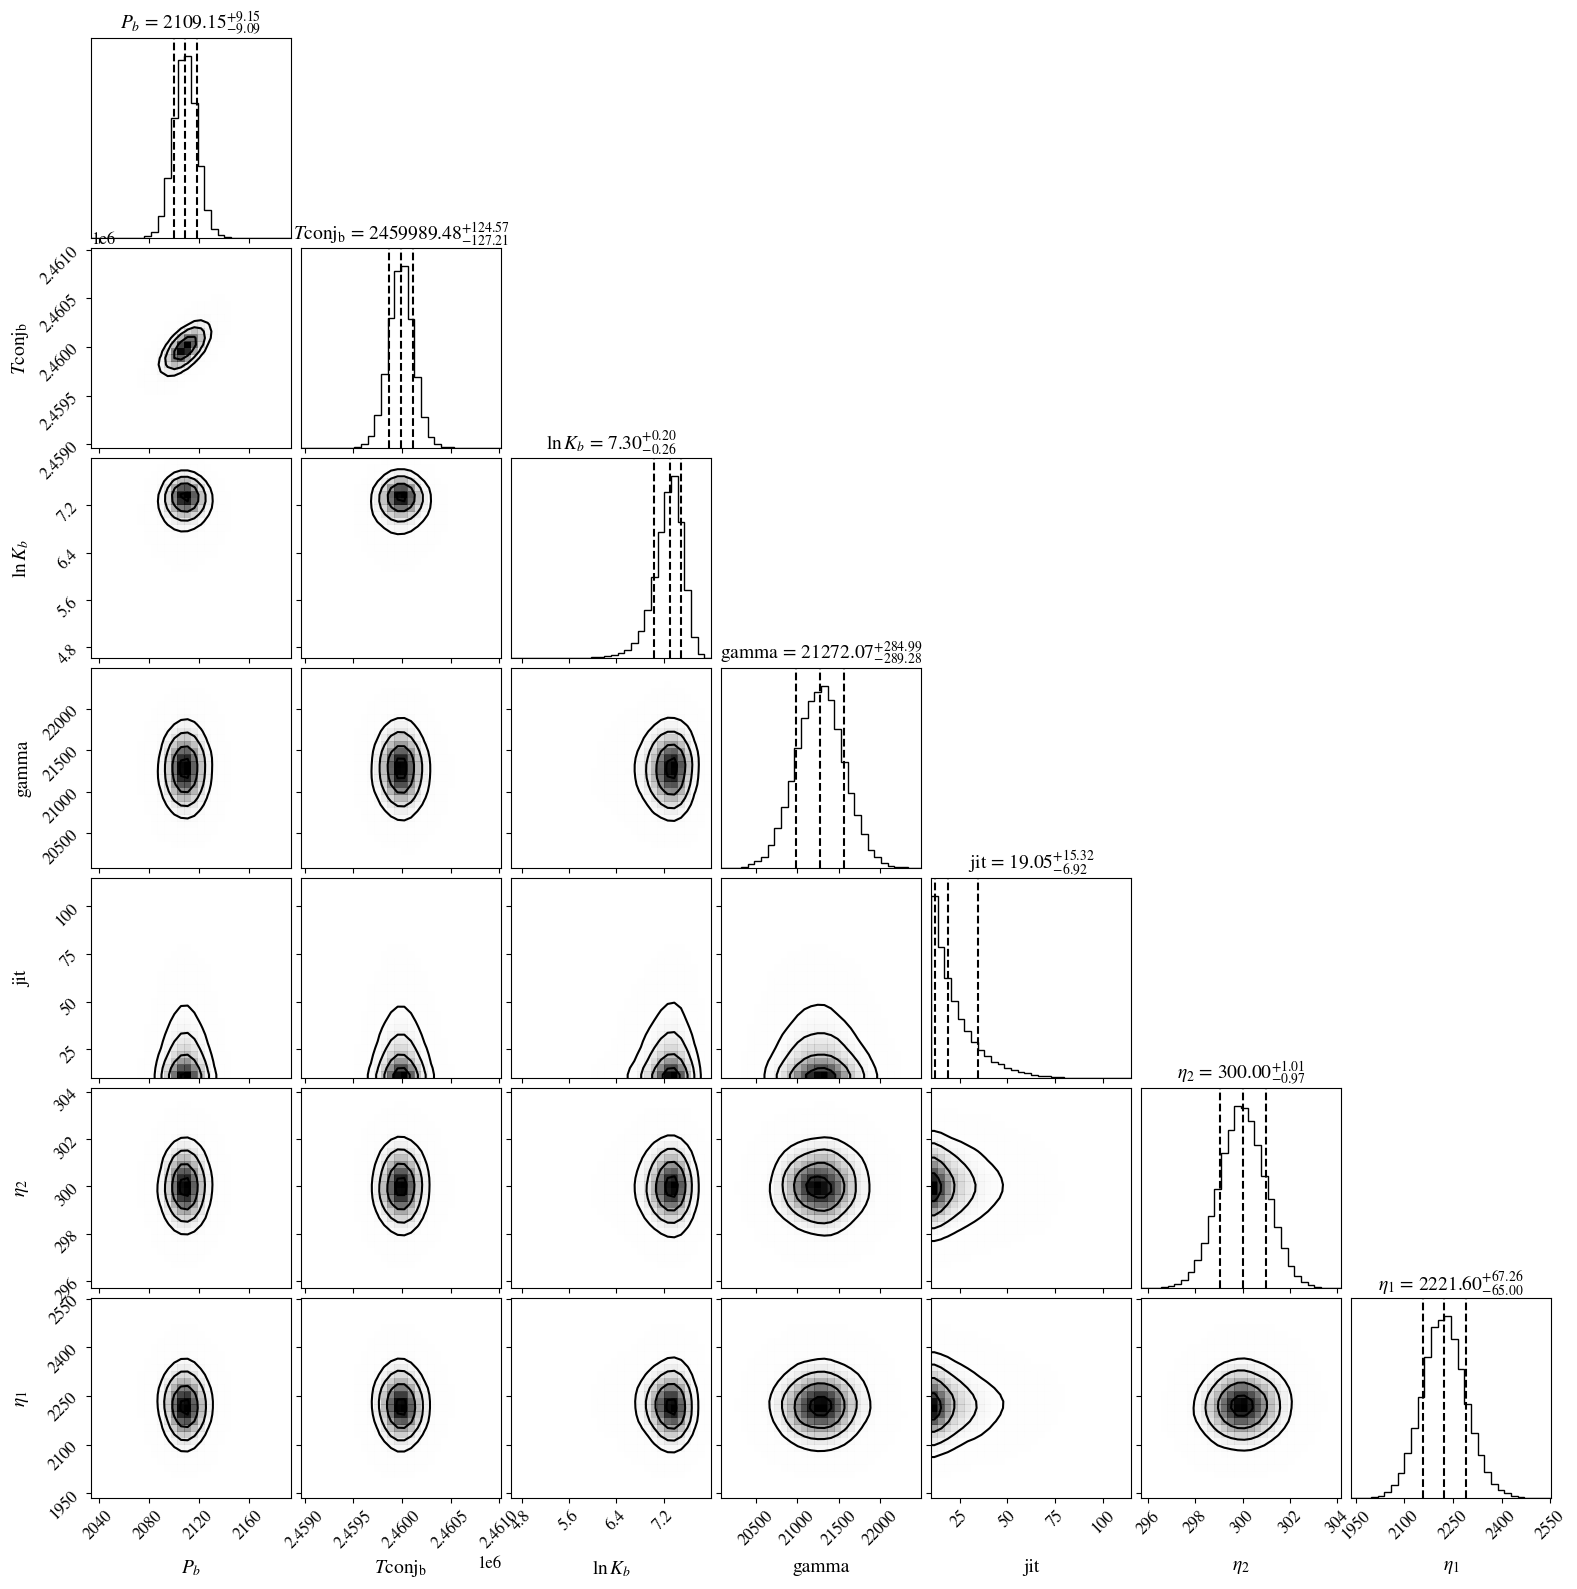

In [235]:
Corner = mcmc_plots.CornerPlot(gppost, gpchains)
Corner.saveplot = "figs/corner_mcmc_full_circ.pdf"
Corner.plot()



In [236]:
def L_calc(R,Teff):
    return 4*np.pi*R**2 * c.sigmaSB * Teff**4 

def R_calc(M,Pdays=416):
    """assuming FM mode has omega_alpha = 1.5 [dimensionless]"""
    return (Pdays*86400*(1.5*np.sqrt(c.G*M))/(2*np.pi) )**(2/3) 

def gamma_calc(L1,M1,R1):
    return (L1/(M1*R1**2))**(1/3)

def tdecay_calcM1M2a(M1,M2,a,Pfmdays=416,Teff=3600):
    """ return tidal decay timescale in yr"""
    R1 = R_calc(M1)
    L1 = L_calc(R1,Teff=Teff)
    gam = gamma_calc(L1,M1,R1)
    q = M2/M1
    M = M1+M2
    return (q*(1+q)*gam)**-1 * (a/R1)**8 /c.yr


df_synth = gppost.params.basis.to_synth(gpchains)
df_synth['tc1_year'] = Time(df_synth['tc1'],format='jd').jyear
df_synth['M1'] = np.random.uniform(low=10,high=25,size=len(df_synth))
df_synth['M2sini'] = radvel.utils.Msini(df_synth['k1'],df_synth['per1'],df_synth['M1'],df_synth['e1'],Msini_units='jupiter') / 1047.57
df_synth['qsini'] = df_synth['M2sini']/df_synth['M1']
df_synth['a'] = radvel.utils.semi_major_axis(df_synth['per1'],df_synth['M1']+df_synth['M2sini'])
df_synth['log_tdecay']= np.log10( tdecay_calcM1M2a(df_synth['M1']*c.msun,
                                     df_synth['M2sini']*c.msun,
                                     df_synth['a']*c.au,
                                     Pfmdays=416,Teff=3600) )
df_synth['k1_kms'] = df_synth['k1']/1000.
df_synth['logk1_kms'] = np.log(df_synth['k1_kms'])
df_synth['gamma_kms']= df_synth['gamma']/1000
df_synth['jit_kms'] = df_synth['jit']/1000
df_synth['gp_amp_kms']= df_synth['gp_amp']/1000
df_synth['f_msun'] = df_synth['per1']*86400 * (df_synth['k1_kms']*1.e5)**3 / (2*np.pi*c.G) / (1e-4*c.msun)
df_synth['k2_kms'] =  df_synth['k1']/1000. / df_synth['qsini']

labels = 'per1 tc1 tc1_year e1 k1_kms logk1_kms gamma M2sini qsini log_tdecay k2_kms'.split()
df_synth[labels].quantile([0.01,0.05,0.14,0.5,0.84,0.95,0.99]).T

0.01          0.05          0.14          0.50  \
per1        2.087015e+03  2.093902e+03  2.099227e+03  2.109153e+03   
tc1         2.459677e+06  2.459774e+06  2.459850e+06  2.459989e+06   
tc1_year    2.022264e+03  2.022530e+03  2.022739e+03  2.023120e+03   
e1          0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
k1_kms      6.316127e-01  9.023710e-01  1.109620e+00  1.480971e+00   
logk1_kms  -4.594788e-01 -1.027295e-01  1.040173e-01  3.926978e-01   
gamma       2.059786e+04  2.079397e+04  2.095803e+04  2.127207e+04   
M2sini      2.336002e-01  3.317335e-01  4.123339e-01  5.831841e-01   
qsini       1.459152e-02  2.082361e-02  2.559382e-02  3.455238e-02   
log_tdecay  4.378244e+00  4.441717e+00  4.501996e+00  4.630646e+00   
k2_kms      3.594857e+01  3.664348e+01  3.811239e+01  4.310298e+01   

                    0.84          0.95          0.99  
per1        2.118298e+03  2.124558e+03  2.131909e+03  
tc1         2.460114e+06  2.460203e+06  2.460307e+06  
tc1_year    2.023461e+03  2.023704e+03  2.023988e+03  
e1          0.000000e+00  0.000000e+00  0.000000e+00  
k1_kms      1.809742e+00  2.028099e+00  2.265549e+00  
logk1_kms   5.931844e-01  7.070990e-01  8.178172e-01  
gamma       2.155706e+04  2.174889e+04  2.194843e+04  
M2sini      7.681888e-01  8.952390e-01  1.028542e+00  
qsini       4.317457e-02  4.921739e-02  5.586827e-02  
log_tdecay  4.756248e+00  4.855492e+00  5.004469e+00  
k2_kms      4.692914e+01  4.805821e+01  4.844926e+01

In [237]:
df_synth['tc1'].quantile(.50)

2459989.4811180565

In [238]:
radvel.utils.semi_major_axis(2110.4,17.5*(1+0.04)) * c.au/c.rsun

1821.8075156428035

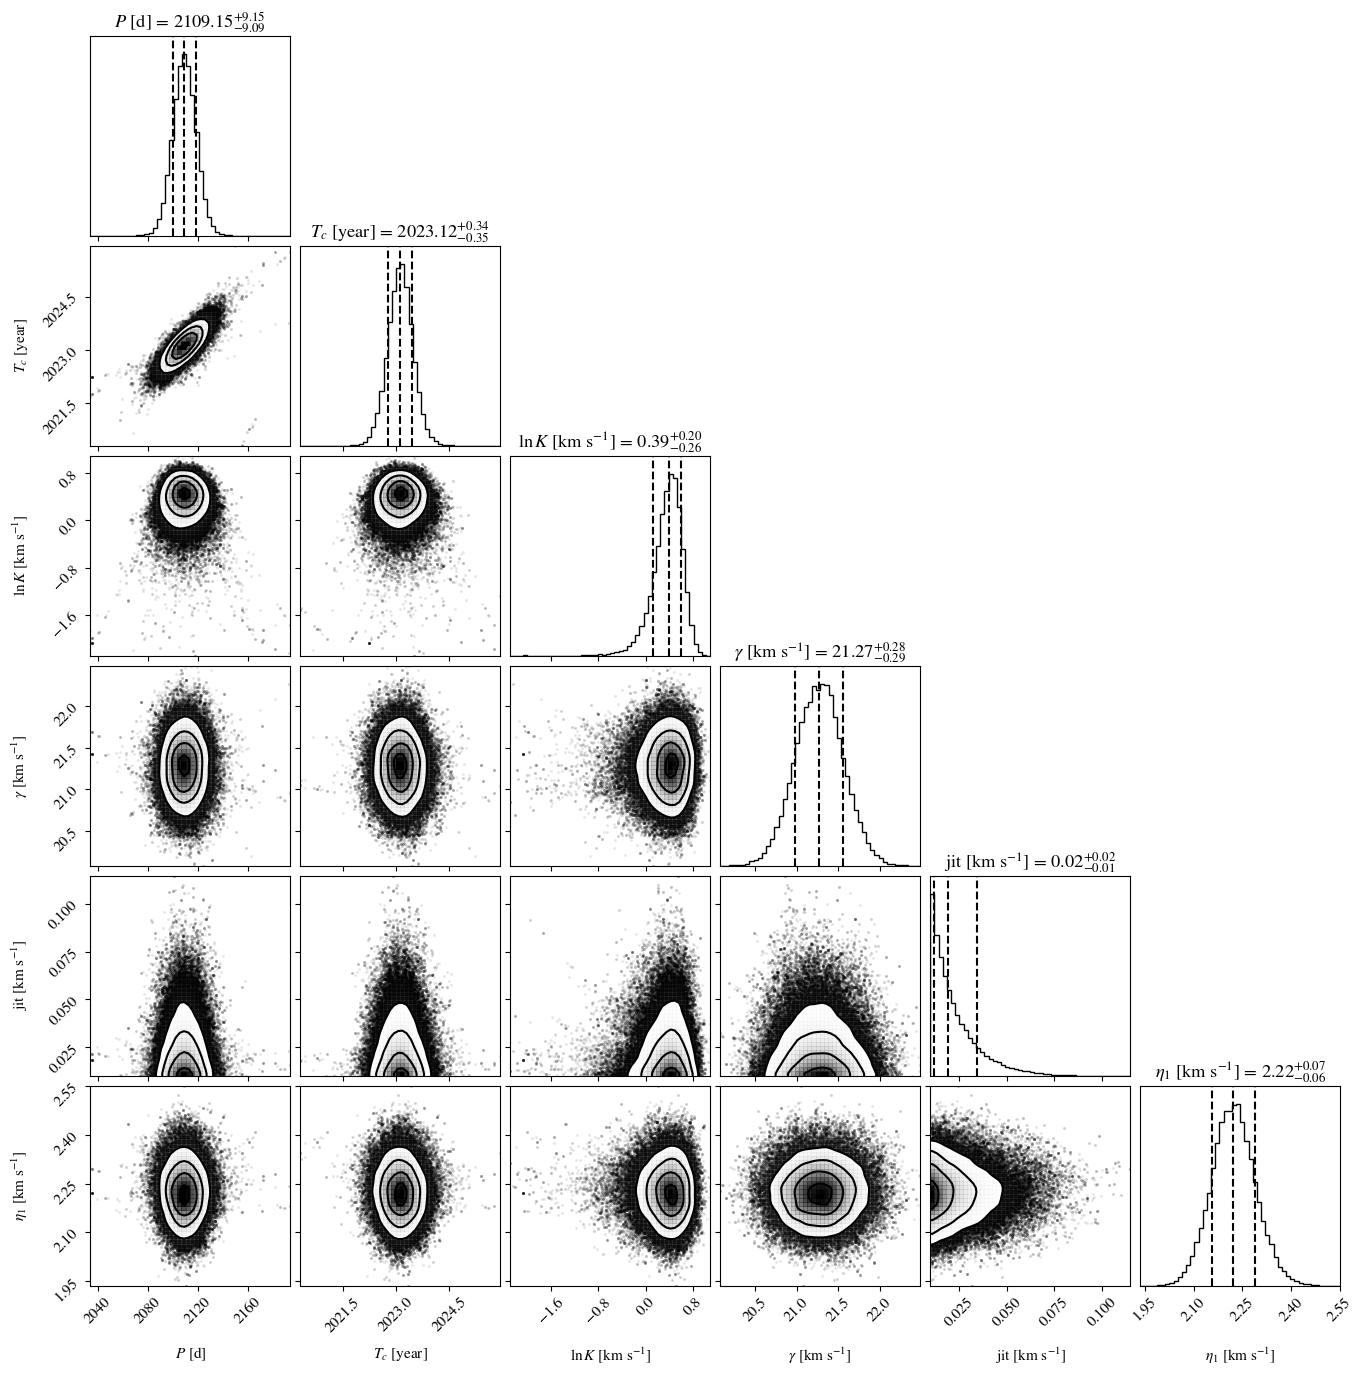

In [239]:
labels = 'per1 tc1_year logk1_kms gamma_kms jit_kms gp_amp_kms'.split()

fig = corner.corner(
    df_synth[labels],
    plot_datapoints=True,smooth=True,
    show_titles=True,bins=48,
    quantiles=[0.16,0.5,0.84],
    labels=["$P$ [d]", "$T_c$ [year]","$\ln K$ [km s$^{-1}$]", "$\gamma$ [km s$^{-1}$]", "jit [km s$^{-1}$]", "$\eta_1$ [km s$^{-1}$]"]
    )

fig.savefig("figs/corner_mcmc_synth_full.pdf",dpi=300)

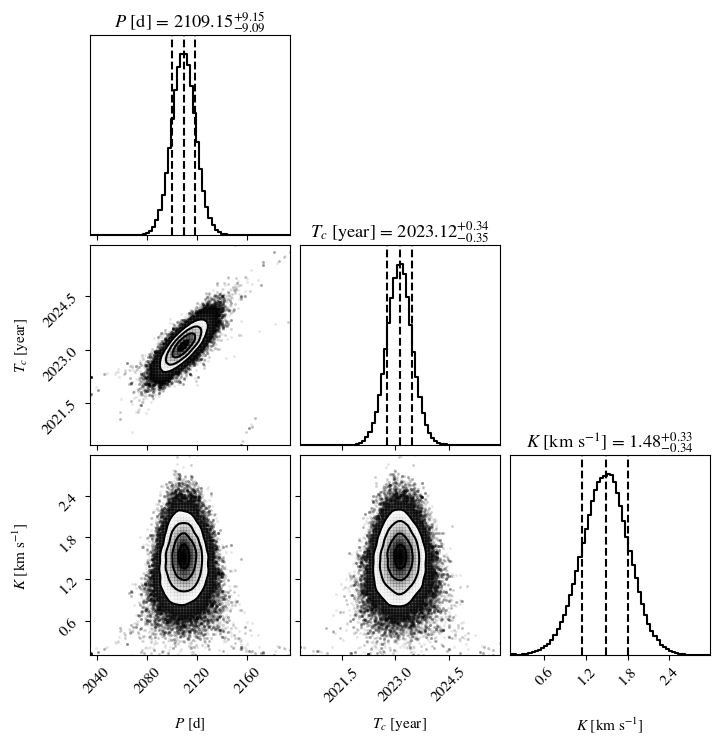

In [240]:
labels = 'per1 tc1_year k1_kms'.split()


fig=corner.corner(
    df_synth[labels],
    plot_datapoints=True,smooth=True,smooth1d=True,
    show_titles=True,bins=64,
    quantiles=[0.16,0.5,0.84],
    labels=["$P$ [d]", "$T_c$ [year]","$K$ [km s$^{-1}$]"]    
    )

fig.savefig("figs/corner_mcmc_synth.pdf",dpi=300)

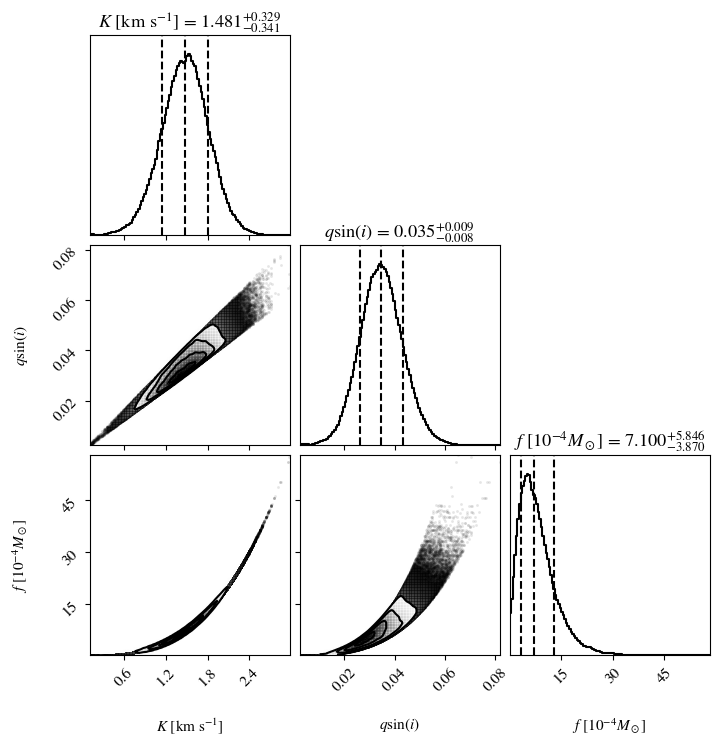

In [241]:
labels = 'k1_kms qsini f_msun'.split()

fig = corner.corner(
    df_synth[labels],
    plot_datapoints=True,smooth=True,smooth1d=True,
    show_titles=True,bins=128,
    title_fmt='.3f',
    quantiles=[0.16,0.5,0.84],
    labels=[ "$K$ [km s$^{-1}$]", "$q\sin(i)$", "$f$ [$10^{-4} M_\odot$]"]
    )


fig.savefig("figs/corner_mcmc_synth_Kqf.pdf",dpi=300)

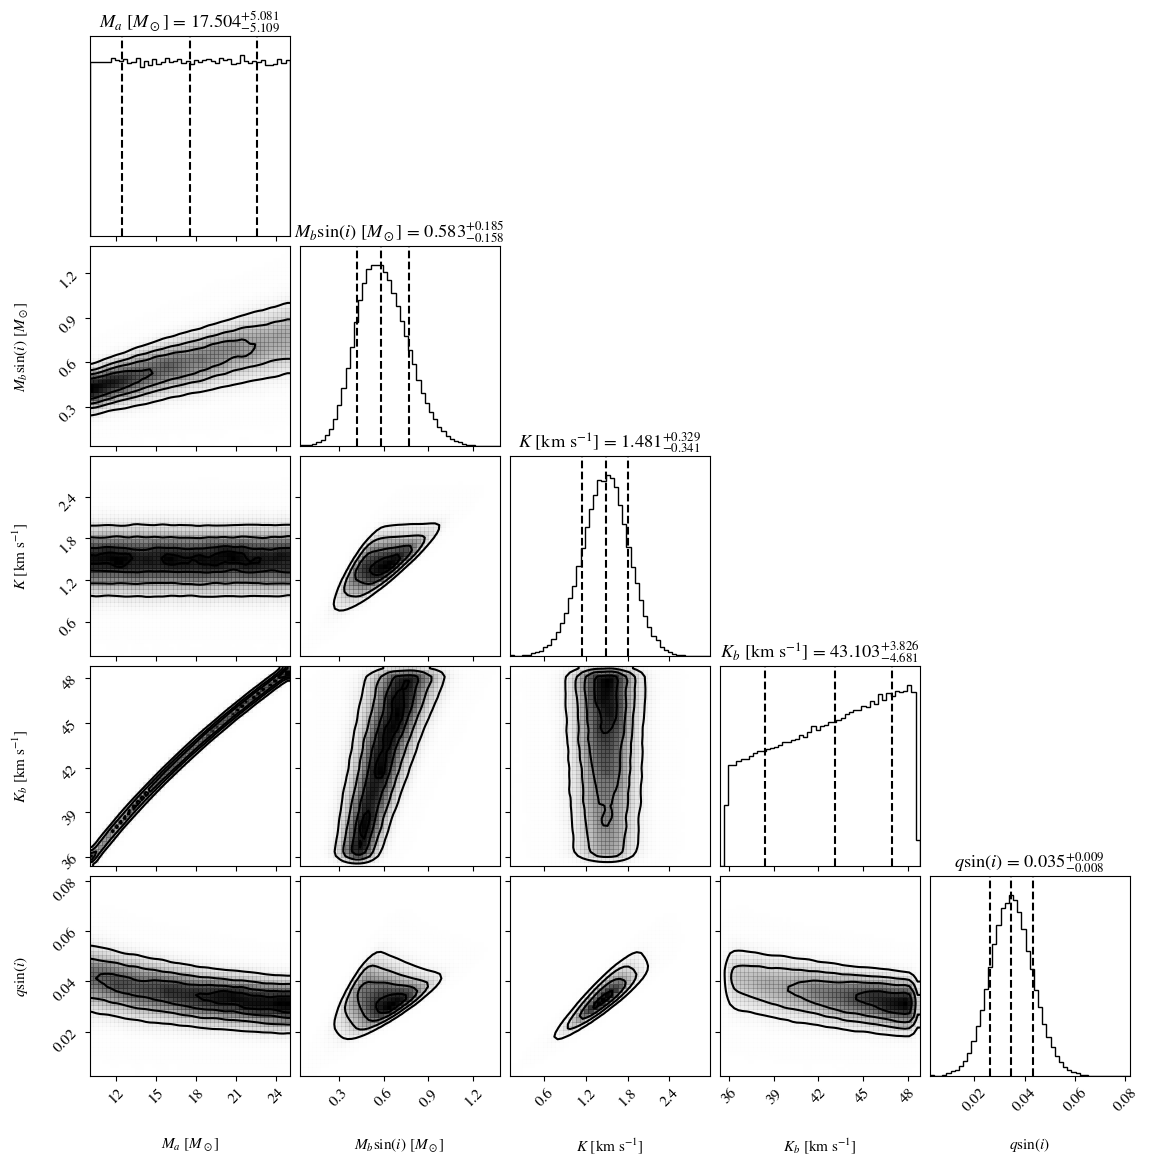

In [242]:
labels = 'M1 M2sini k1_kms k2_kms qsini'.split()

fig = corner.corner(
    df_synth[labels],
    plot_datapoints=False,smooth=True,
    show_titles=True,bins=48,
    title_fmt='.3f',
    quantiles=[0.16,0.5,0.84],
    labels=["$M_a$ [$M_\odot$]","$M_b \sin(i)$ [$M_\odot$]", "$K$ [km s$^{-1}$]",  "$K_b$ [km s$^{-1}$]", "$q\sin(i)$"]
    )



In [261]:
df_synth['k2_kms'][np.abs(df_synth['M1']-17.5)<0.1].quantile([0.14,0.5,0.84])

0.14    43.016338
0.50    43.101606
0.84    43.183266
Name: k2_kms, dtype: float64

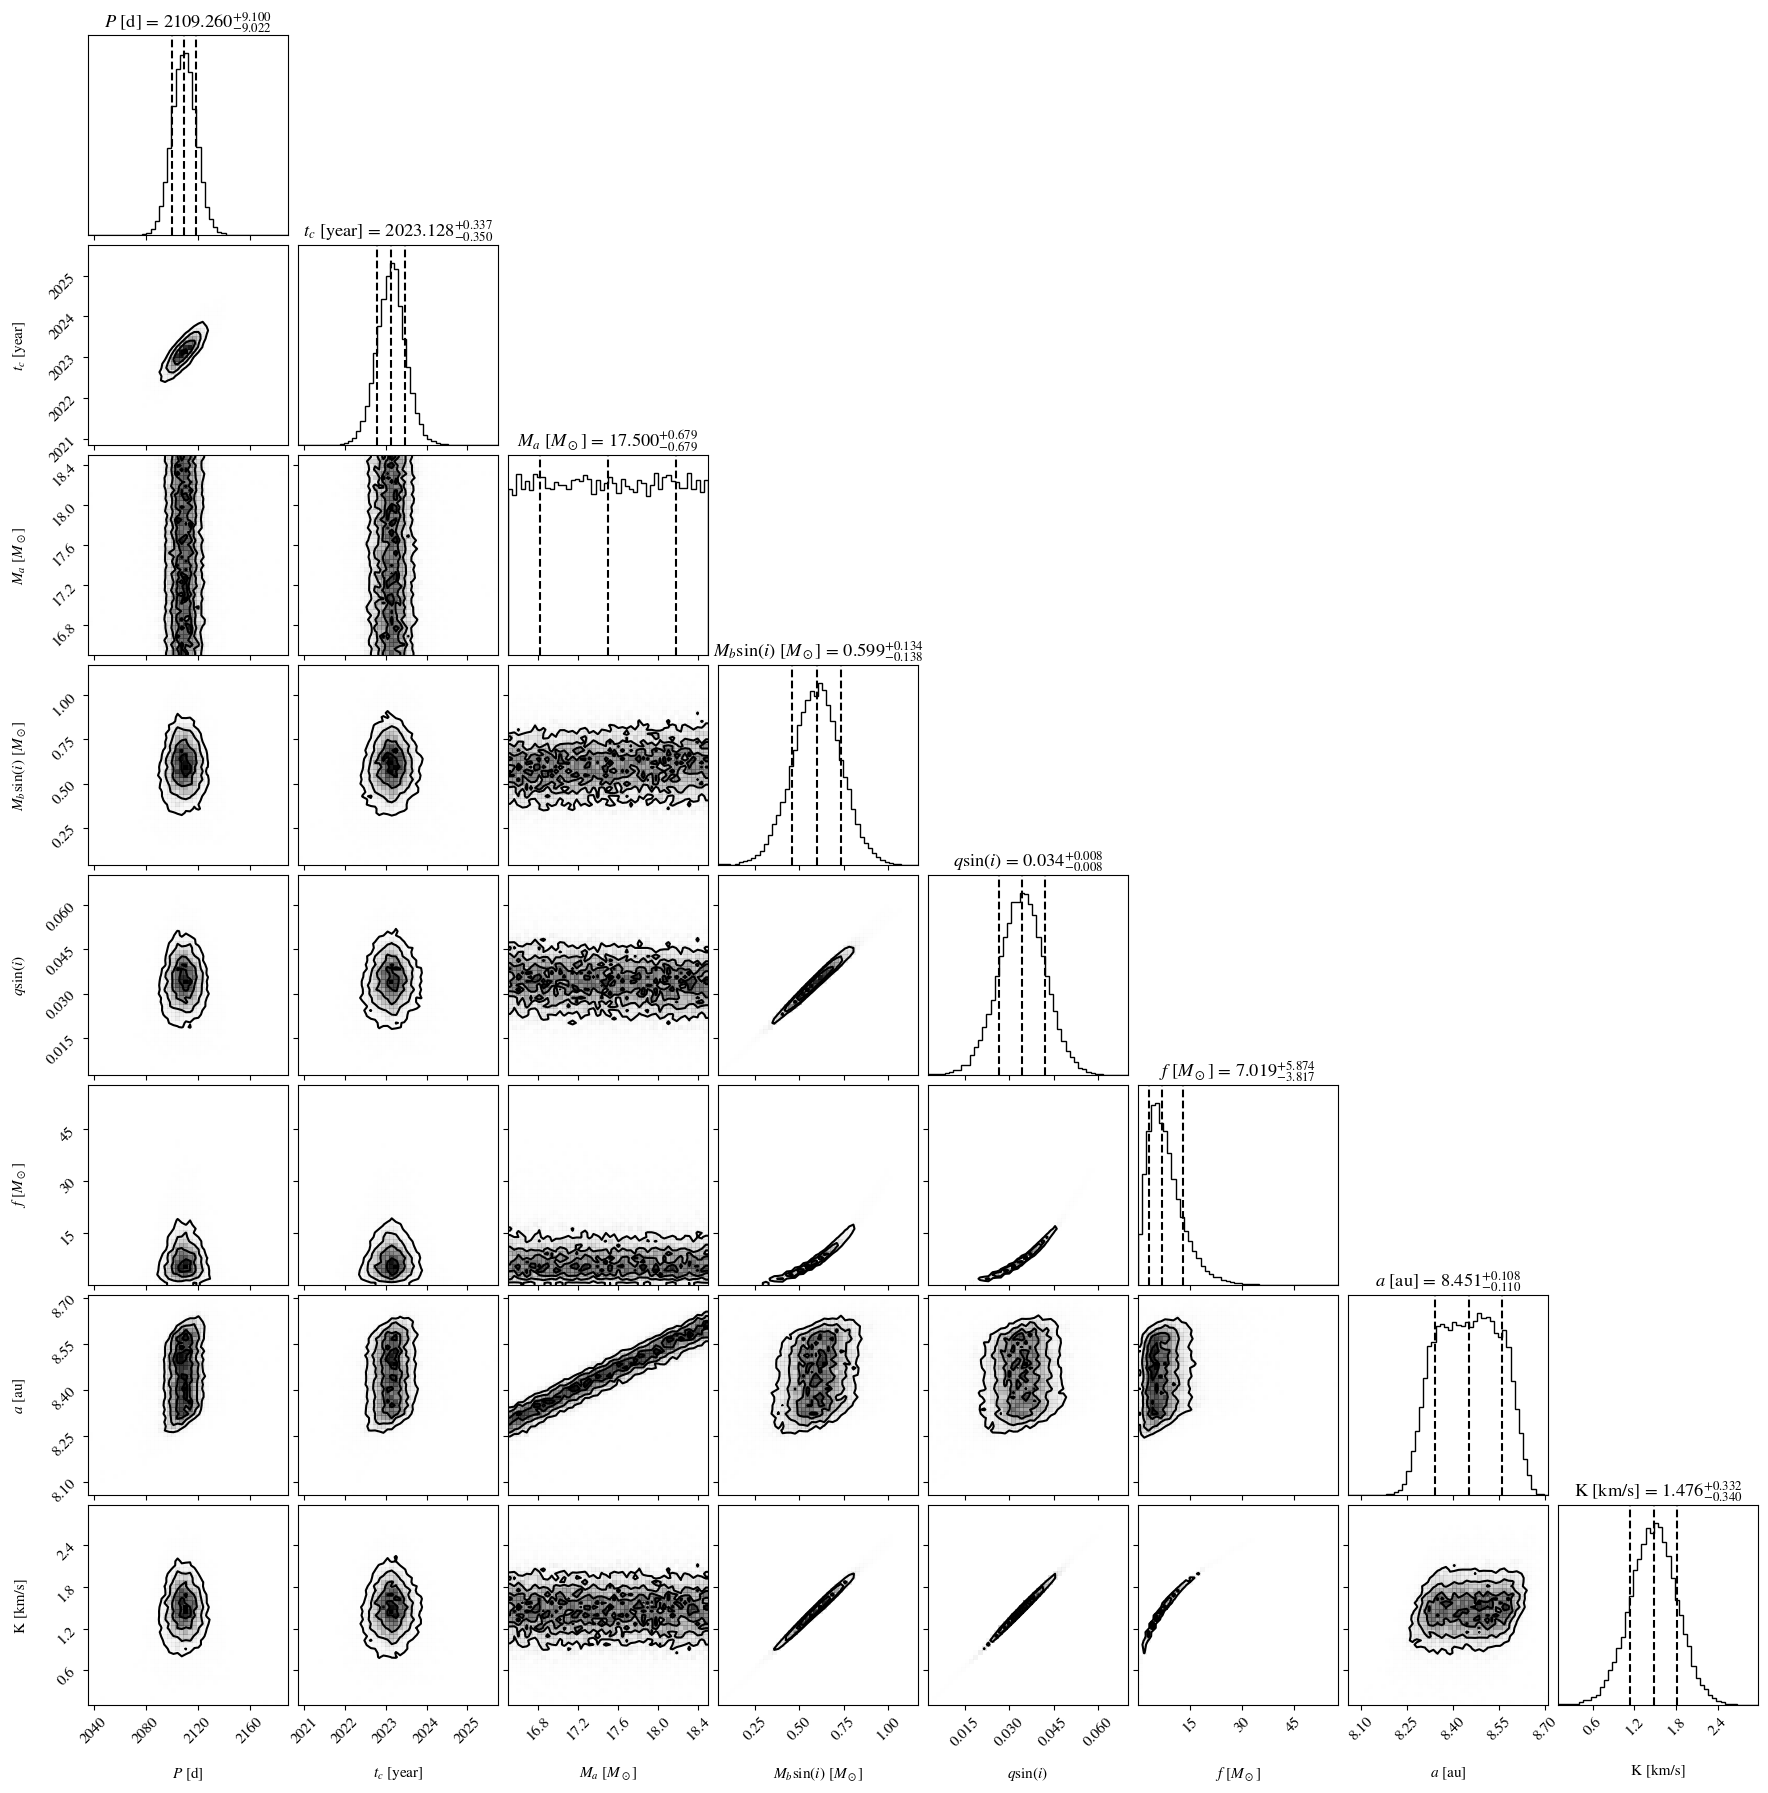

In [260]:
labels = 'per1 tc1_year M1 M2sini qsini f_msun a k1_kms'.split()

sel = np.abs(df_synth['M1']-17.5)<1

fig = corner.corner(
    df_synth[labels][sel],
    plot_datapoints=False,smooth=False,
    show_titles=True,bins=48,
    title_fmt='.3f',
    quantiles=[0.16,0.5,0.84],
    labels=["$P$ [d]", "$t_c$ [year]",
            "$M_a$ [$M_\odot$]","$M_b \sin(i)$ [$M_\odot$]",
            "$q\sin(i)$","$f$ [$M_\odot$]","$a$ [au]","K [km/s]"]
    )


#fig.savefig("figs/corner_mcmc_synth_allphys.pdf",dpi=300)

In [254]:
2.68/1.476 * 0.034

0.061734417344173446

In [258]:
0.03*c.au/c.rsun

6.452911574406902

In [193]:
1816*(20.5/17.5)**(1/3) / 842

2.273573630098538

In [194]:
20.5*0.01

0.20500000000000002

In [195]:
(20.5/17.5)**(-1/3) * 0.031

0.02940738606265746

In [196]:
17.5*0.009

0.1575

In [197]:
8.442*c.au/c.rsun

1815.849317038102

In [198]:
sel = np.abs(df_synth['M1']-17.5)<0.01
((df_synth['k1_kms']/df_synth['qsini'])[sel]).quantile((0.16,0.5,0.84))

0.16    43.049162
0.50    43.107759
0.84    43.163883
dtype: float64

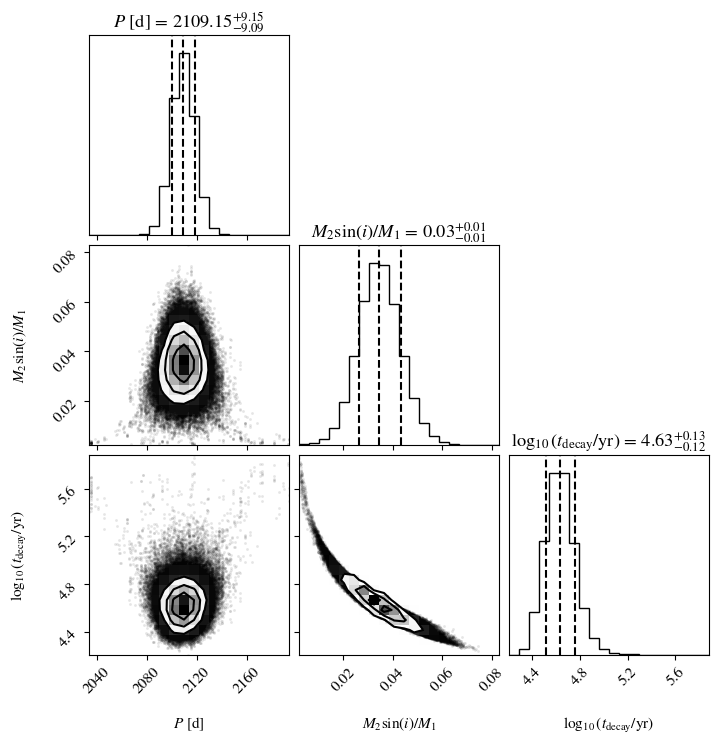

In [199]:
labels = 'per1 qsini log_tdecay'.split()

fig = corner.corner(
    df_synth[labels],
    plot_datapoints=True,smooth=False,
    show_titles=True,#bins=16,
    quantiles=[0.16,0.5,0.84],
    labels=["$P$ [d]","$M_2 \sin (i)/ M_1$",r"$\log_{10}(t_{\rm decay}/{\rm yr})$"]
    )

fig.savefig("figs/corner_mcmc_synth_LFtide.pdf",dpi=300)

In [200]:
def initialize_model_from_chain(ind,chain):
    if ind == -99:
        ind = random.randint(0,len(chain)-1)
    index_dict = chain.iloc[ind].to_dict()
    params = radvel.Parameters(1,basis='per tc secosw sesinw logk') 
    for pp in index_dict:
        params[pp] = radvel.Parameter(value=index_dict[pp],vary=False)
    mod = radvel.RVModel(params)
    return mod
    
    
def initialize_model_from_chain_circ(ind,chain):
    if ind == -99:
        ind = random.randint(0,len(chain)-1)
    index_dict = chain.iloc[ind].to_dict()
    params = radvel.Parameters(1,basis='per tc secosw sesinw logk') 
    print('Model index: ',index_dict)
    for pp in index_dict:
        params[pp] = radvel.Parameter(value=index_dict[pp],vary=False)
    params['secosw1'] = radvel.Parameter(value=0.0,vary=False)
    params['sesinw1'] = radvel.Parameter(value=0.0,vary=False)
    mod = radvel.RVModel(params)
    return mod


## NEAR-CIRCULAR SAMPLES, MEDIAN VALUES 
gpcirc = gpchains.copy()
#mymod = initialize_model_from_chain_circ(gpchains.lnprobability.argmax(),gpchains)
#for key in mymod.params.keys():
#    print("{:<13}".format(key),mymod.params[key])

mean_circ_params = radvel.Parameters(1,basis='per tc secosw sesinw logk')

mean_circ_params['per1'] = radvel.Parameter(value = gpcirc.quantile(0.5).per1)
mean_circ_params['tc1']  = radvel.Parameter(value = gpcirc.quantile(0.5).tc1 )
mean_circ_params['secosw1'] = radvel.Parameter(value = 0)
mean_circ_params['sesinw1'] = radvel.Parameter(value = 0)
mean_circ_params['logk1'] = radvel.Parameter(value=gpcirc.quantile(0.5).logk1)
mean_circ_params['gp_amp'] = radvel.Parameter(value=gpcirc.quantile(0.5).gp_amp)
mean_circ_params['gp_length'] = radvel.Parameter(value=gpcirc.quantile(0.5).gp_length)
mean_circ_params['jit'] = radvel.Parameter(value=gpcirc.quantile(0.5).jit)
mean_circ_params['gamma'] = radvel.Parameter(value=gpcirc.quantile(0.5).gamma)

mean_circ_params

print("mean tc1 = ",Time(2459999.132909865,format='jd').jyear)

# MODEL AND LIKE
mymod = radvel.RVModel(mean_circ_params)
for key in mymod.params.keys():
    print("{:<13}".format(key),mymod.params[key])
mylike = radvel.likelihood.GPLikelihood(mymod, gppost.likelihood.x, gppost.likelihood.y, gppost.likelihood.yerr,
                                    hnames=['gp_amp','gp_length'],kernel_name='Exp')

# ARRAYS
t = mylike.x
vel = mylike.y
errvel = mylike.yerr

gpmu,stddev = mylike.predict(t)

### GET FLATTENED ARRAYS
vel_flat = vel - gpmu - mylike.params['gamma'].value
errvel_flat = np.sqrt(errvel**2 + mylike.params['jit'].value**2 + stddev**2)
errvel_flat_nojit = np.sqrt(errvel**2 + stddev**2)

mean tc1 =  2023.1461544417937
per1          Parameter object: value = 2109.1526989129206, vary = True, mcmc scale = None
tc1           Parameter object: value = 2459989.4811180565, vary = True, mcmc scale = None
secosw1       Parameter object: value = 0, vary = True, mcmc scale = None
sesinw1       Parameter object: value = 0, vary = True, mcmc scale = None
logk1         Parameter object: value = 7.300453085755259, vary = True, mcmc scale = None
gp_amp        Parameter object: value = 2221.604643685685, vary = True, mcmc scale = None
gp_length     Parameter object: value = 299.9976489498289, vary = True, mcmc scale = None
jit           Parameter object: value = 19.045652709415727, vary = True, mcmc scale = None
gamma         Parameter object: value = 21272.071030948144, vary = True, mcmc scale = None


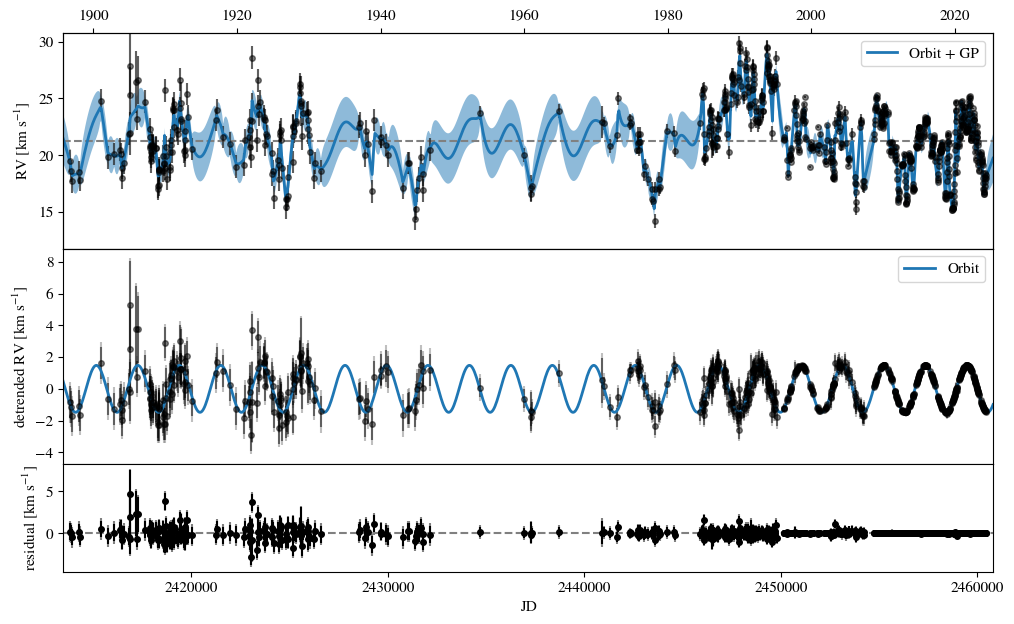

In [201]:
mean_jit = mylike.params['jit'].value #np.mean(gpcirc['jit'])
nlines = 1
yrange = 19

ms = 4


fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(12, 7),
                       gridspec_kw={'height_ratios': [2,2,1],'hspace': 0},sharex=True)




ti = np.linspace(mylike.x[0]-365,mylike.x[-1]+365,1000)
gpmu,stddev = mylike.predict(ti)



axs[0].set_ylabel('RV [km s$^{-1}$]')
axs[0].plot(ti,np.ones_like(ti)*mylike.params['gamma'].value/vfactor,ls='--',color='grey')
axs[0].errorbar(mylike.x,mylike.y/vfactor,np.sqrt(mylike.yerr**2 + mean_jit**2)/vfactor,marker='',
                linestyle='',color='grey',alpha=0.5)
axs[0].errorbar(mylike.x,mylike.y/vfactor,mylike.yerr/vfactor,marker='o',
                linestyle='',color='k',alpha=0.5,markersize=ms)


axs[0].fill_between(ti,
                    (mymod(ti)+gpmu + stddev + mymod.params['gamma'].value)/vfactor,
                    (mymod(ti)+gpmu - stddev + mymod.params['gamma'].value)/vfactor,color='C0',alpha=0.5,label='',edgecolor=None)
axs[0].plot(ti,(mymod(ti)+ gpmu + mymod.params['gamma'].value)/vfactor ,color='C0',alpha=1,lw=2,label='Orbit + GP')

axs[0].legend(loc=0)
axs[0].set_ylim(-yrange/2+mylike.params['gamma'].value/vfactor,
                 yrange/2+mylike.params['gamma'].value/vfactor)
axs[0].set_xlim(ti[0],ti[-1])
ayr = axs[0].twiny()
ayr.set_xlim(Time(ti[0],format='jd').jyear, Time(ti[-1],format='jd').jyear)


axs[1].set_ylabel('detrended RV [km s$^{-1}$]')
axs[1].errorbar(mylike.x,(mylike.y-mylike.predict(mylike.x)[0]-mylike.params['gamma'].value)/vfactor,
                np.sqrt(mylike.yerr**2 + mean_jit**2 + mylike.predict(mylike.x)[1]**2)/vfactor,marker='',linestyle='',color='grey',alpha=0.5)
axs[1].errorbar(mylike.x,(mylike.y-mylike.predict(mylike.x)[0]-mylike.params['gamma'].value)/vfactor,
                mylike.yerr/vfactor,marker='o',linestyle='',color='k',alpha=0.5,markersize=ms)
axs[1].plot(ti,mymod(ti)/vfactor ,color='C0',alpha=1,lw=2,label='Orbit')
axs[1].legend(loc=0)

axs[2].set_ylabel('residual [km s$^{-1}$]')
axs[2].plot(ti,np.zeros_like(ti),ls='--',color='grey')

axs[2].errorbar(mylike.x,(mylike.y-mylike.predict(mylike.x)[0]-mylike.params['gamma'].value-mylike.model(mylike.x))/vfactor,
                np.sqrt(mylike.yerr**2 + mean_jit**2 + mylike.predict(mylike.x)[1]**2)/vfactor,marker='',linestyle='',color='grey')
axs[2].errorbar(mylike.x,(mylike.y-mylike.predict(mylike.x)[0]-mylike.params['gamma'].value-mylike.model(mylike.x))/vfactor,
                mylike.yerr/vfactor,marker='o',linestyle='',color='k',markersize=ms)
#axs[1].set_ylim(-yrange/2,yrange/2)
axs[2].set_xticks([2420000,2430000,2440000,2450000,2460000])
axs[2].xaxis.set_major_formatter(ticker.FormatStrFormatter("%i"))
axs[2].set_xlabel('JD')

"""
mylw = 1
myalpha = 0.25
for i in range(nlines):
    mymod = initialize_model_from_chain(-99,gpcirc)
    mylike = radvel.likelihood.GPLikelihood(mymod, mylike.x, mylike.y, mylike.yerr,
                                        hnames=['gp_amp','gp_length'],kernel_name='SqExp')
    gpmu,stddev = mylike.predict(ti)
    
    axs[0].plot(ti,(gpmu + mymod.params['gamma'].value)/vfactor,color='C1',alpha=myalpha,lw=mylw)
    axs[0].plot(ti,(mymod(ti)+ gpmu + mymod.params['gamma'].value)/vfactor ,color='C0',alpha=myalpha,lw=mylw)
    
"""

plt.subplots_adjust(hspace=0)


#rva = Table.read('RVs/BG_rv10.csv')
#axs[0].errorbar(rva['JD'],rva['RV'],rva['RV_err'],color='r',marker='x',linestyle='')

fig.savefig("figs/RV_timeseries_model.pdf",bbox_inches='tight',dpi=300)

Model: Sine1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
         amplitude      frequency        phase        
    ------------------- --------- --------------------
    0.07180461538201265       1.0 -0.27064220932153343
phi= -1.700495153111681 4.582690154067905


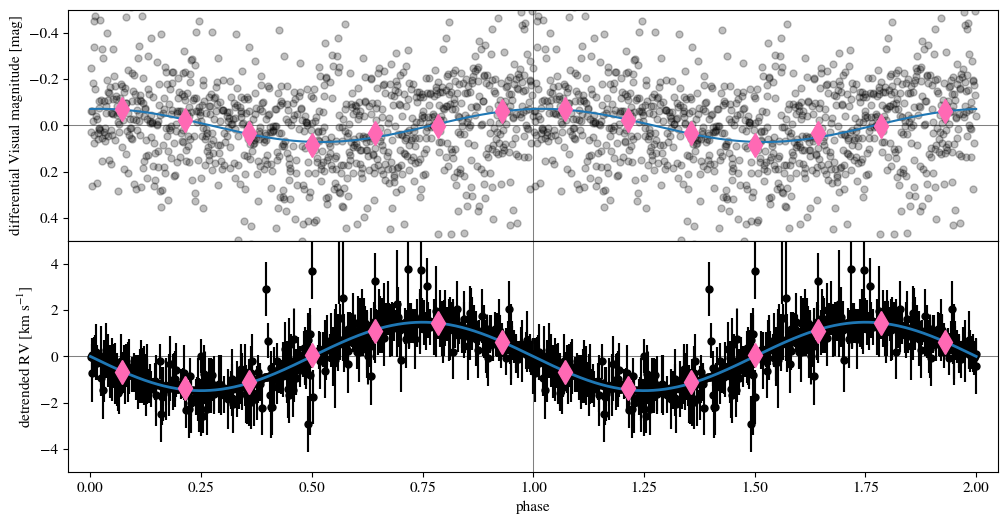

In [219]:

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(12, 6),
                       gridspec_kw={'height_ratios': [1,1],'hspace': 0},sharex=True)


mph = orbit_plots.t_to_phase(mean_circ_params,aavsoT['JD'],1)
axs[0].plot(mph,aavsoT['mag_flat'],'ko',alpha=0.25)
axs[0].plot(mph+1,aavsoT['mag_flat'],'ko',alpha=0.25)



m_init = models.Sine1D(frequency=1.,amplitude=0.08,
                       fixed={'frequency':True,'amplitude':False})
fit_m = fitting.LevMarLSQFitter()
m = fit_m(m_init, mph,aavsoT['mag_flat'] )
print(m)
print("phi=",m.phase*2*np.pi, (1+m.phase)*2.*np.pi)


mxph = np.linspace(0,2,1000)
axs[0].plot(mxph,m(mxph))
#axs[0].plot(mxph,0.05*np.sin(2*np.pi*mxph+0.3*2*np.pi))
#axs[0].axhline(0)


#myph = m.amplitude*np.sin(2*np.pi*(mxph + m.phase + 1)) 
#axs[0].plot(mxph,myph,'--',color='HotPink')


bins = np.linspace(0,1,8)
xpm = (bins[1:]+bins[:-1])/2
ypm = np.zeros_like(xpm)
for i in range(len(bins)-1):
    sel = (mph >= bins[i]) & (mph < bins[i+1])
    ypm[i] = np.nanmean(aavsoT['mag_flat'][sel])

axs[0].plot(xpm,ypm,'d',markersize=12,color='HotPink')
axs[0].plot(1+xpm,ypm,'d',markersize=12,color='HotPink')

axs[0].set_ylim(0.5,-0.5)
axs[0].axhline(0,color='grey',lw=0.75,zorder=0)
#axs[0].axvline(0,color='grey',lw=0.75,zorder=0)
axs[0].axvline(1,color='grey',lw=0.75,zorder=0)
#axs[0].axvline(2,color='grey',lw=0.75,zorder=0)

yrange = 17
ph = orbit_plots.t_to_phase(mean_circ_params,t,1)

xph = np.linspace(0,2,1000)
yph = -np.exp(mean_circ_params['logk1'].value)*np.sin(2*np.pi*xph)
#yph_interp = np.interp(ph,xph,yph)


axs[1].errorbar(ph,vel_flat/vfactor,errvel_flat/vfactor,marker='',color='grey',ls='')
axs[1].errorbar(ph,vel_flat/vfactor,errvel_flat_nojit/vfactor,marker='o',color='k',ls='')
axs[1].errorbar(ph+1,vel_flat/vfactor,errvel_flat/vfactor,marker='',color='grey',ls='')
axs[1].errorbar(ph+1,vel_flat/vfactor,errvel_flat_nojit/vfactor,marker='o',color='k',ls='')

axs[1].plot(xph,yph/vfactor ,"-",color='C0',alpha=1,lw=2,zorder=10)
axs[1].set_ylim(-yrange/2,yrange/2)


bins = np.linspace(0,1,8)
xpm = (bins[1:]+bins[:-1])/2
ypm = np.zeros_like(xpm)
for i in range(len(bins)-1):
    sel = (ph >= bins[i]) & (ph < bins[i+1])
    ypm[i] = np.nanmean(vel_flat[sel])

axs[1].plot(xpm,ypm/vfactor,'d',markersize=12,color='HotPink',zorder=10)
axs[1].plot(1+xpm,ypm/vfactor,'d',markersize=12,color='HotPink',zorder=11)
axs[1].axhline(0,color='grey',lw=0.75,zorder=0)
#axs[1].axvline(0,color='grey',lw=0.75,zorder=0)
axs[1].axvline(1,color='grey',lw=0.75,zorder=0)
#axs[1].axvline(2,color='grey',lw=0.75,zorder=0)

axs[0].set_ylabel('differential Visual magnitude [mag]')
axs[1].set_ylabel('detrended RV [km s$^{-1}$]')
#axs[1].set_ylabel('residual [km s$^{-1}$]')
plt.xlabel('phase')
plt.xlim(-0.05,2.05)
plt.ylim(-5,5)

fig.savefig("figs/phased_lc_rv.pdf",bbox_inches='tight',dpi=300)

In [249]:
3*np.pi/2  -1.700495153111681, (3*np.pi/2 -1.700495153111681)/(2*np.pi)

(3.011893827273009, 0.47935779067846657)

In [250]:
0.479*2109.2

1010.3067999999998

In [248]:
3*np.pi/2 - 0.63*np.pi , (3*np.pi/2 - 0.63*np.pi)/(2*np.pi)

(2.73318560862312, 0.435)

# Drop-Sample Predictiveness: GP 

6 : dropped 249  data points, which is  31.0 %
final time =  2013.9306021184393

 gm= 
 Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude             mean               stddev      
    ----------------- -------------------- ------------------
    149.4662825955544 0.010340609869891862 0.2592294735378071

 gm (drop) = 
 Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude              mean              stddev      
    ------------------ ------------------- ------------------
    32.132693918439394 -0.0894791015936175 0.5577261684861085


UsageError: Line magic function `%plt.title('$P` not found.


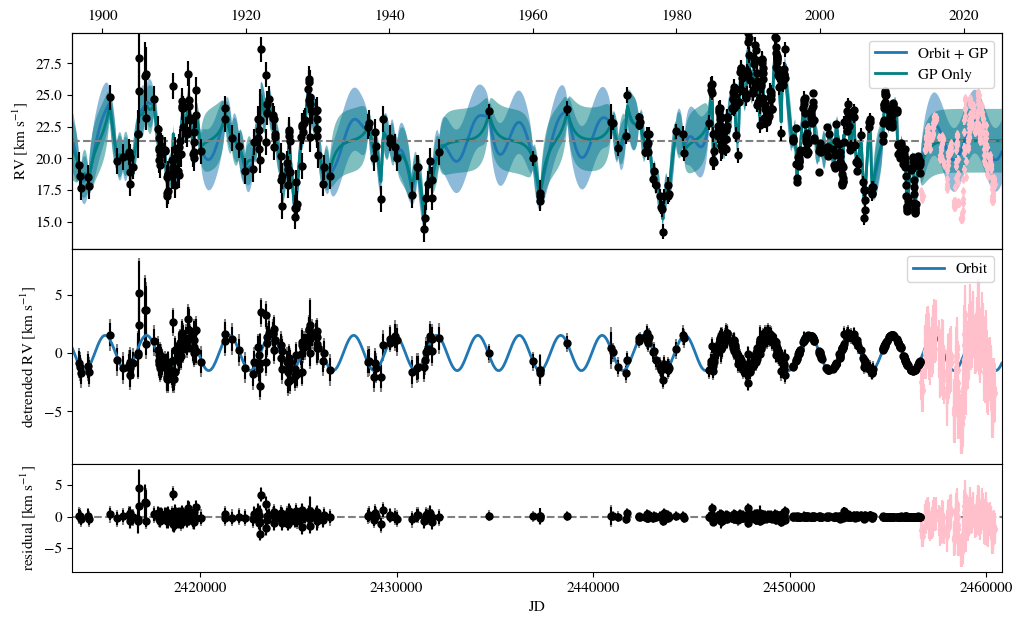

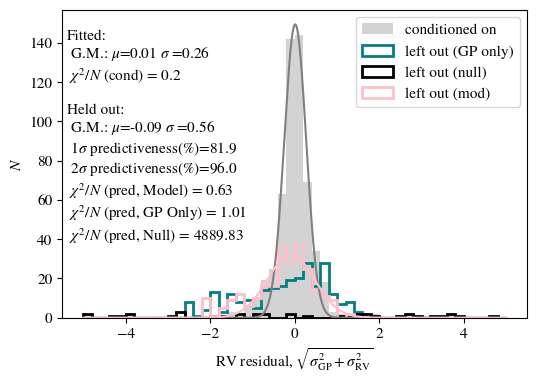

In [209]:
from glob import glob
from copy import copy,deepcopy
from astropy.table import Table
from matplotlib import ticker
from astropy.time import Time

def make_drop_sample_plots(fn,name=""):
    myKernel = 'Exp'


    rv30fn = "RVs/BG_rv30.csv"
    rv365fn = "RVs/BG_rv365.csv"
    rv10fn = "RVs/BG_rv10.csv"

    rvfn = rv10fn

    rv_resid = []
    rv_resid_std = []
    rv_resid_drop = []
    rv_resid_drop_std = []
    rv_resid_drop_null = []
    rv_resid_drop_null_std = []
    rv_resid_drop_gp_only = []
    rv_resid_drop_gp_only_std = []

    vfactor=1e3
    yrange = 17


    gppost = radvel.posterior.load(fn)
    mean_jit = gppost.params['jit'].value
    mymod  = radvel.RVModel(gppost.params)
    mylike = radvel.likelihood.GPLikelihood(mymod, gppost.likelihood.x, gppost.likelihood.y, gppost.likelihood.yerr,
                                        hnames=['gp_amp','gp_length'],kernel_name=myKernel)
    #print(mymod.params['logk1'])

    gp_only_params = deepcopy( gppost.params )
    gp_only_params['logk1'].value = -10 
    gp_only_mod = radvel.RVModel(gp_only_params)
    gp_only_like = radvel.likelihood.GPLikelihood(gp_only_mod, mylike.x, mylike.y, mylike.yerr,
                                    hnames=['gp_amp','gp_length'],kernel_name=myKernel)

    #print(mymod.params['logk1'])
    #print(gp_only_mod.params['logk1'])

    ### ADD FULL SAMPLE
    rva = Table.read(rvfn)
    seldrop = (np.isin( np.round(rva['JD']), np.round(mylike.x) ) == False)
    rvd = rva[seldrop].copy()
    print(i,": dropped", len(rvd), " data points, which is ", np.round(100*len(rvd)/len(rva)), "%")
    print("final time = ",Time(mylike.x[-1],format='jd').jyear)

    ti = np.linspace(rva['JD'][0]-365,rva['JD'][-1]+365,1000)
    gpmu,stddev = mylike.predict(ti)
    gp_only_mu,gp_only_stddev = gp_only_like.predict(ti)

    ## DISPERSION ANALYSIS
    rv_resid.append( (mylike.y-mylike.predict(mylike.x)[0]-mylike.params['gamma'].value-mylike.model(mylike.x))/vfactor )
    rv_resid_std.append( np.sqrt(mylike.yerr**2 + mean_jit**2 + mylike.predict(mylike.x)[1]**2)/vfactor )

    rv_resid_drop.append( rvd['RV']-(mylike.predict(rvd['JD'])[0] +mylike.params['gamma'].value + mylike.model(rvd['JD']))/vfactor )
    rv_resid_drop_std.append(np.sqrt(rvd['RV_err']**2 + (mean_jit/vfactor)**2 + (mylike.predict(rvd['JD'])[1]/vfactor)**2) )

    rv_resid_drop_null.append( rvd['RV']-mylike.params['gamma'].value/vfactor )
    rv_resid_drop_null_std.append( np.sqrt(rvd['RV_err']**2 + (mean_jit/vfactor)**2) )

    rv_resid_drop_gp_only.append( rvd['RV']-(gp_only_like.predict(rvd['JD'])[0] + mylike.params['gamma'].value )/vfactor )
    rv_resid_drop_gp_only_std.append( np.sqrt(rvd['RV_err']**2 + (mean_jit/vfactor)**2 + (gp_only_like.predict(rvd['JD'])[1]/vfactor)**2) )


    # TS FIGURE 
    fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(12, 7),
                           gridspec_kw={'height_ratios': [2,2,1],'hspace': 0},sharex=True)

    axs[0].set_ylabel('RV [km s$^{-1}$]')
    axs[0].fill_between(ti,
                        (mymod(ti)+gpmu + stddev + mymod.params['gamma'].value)/vfactor,
                        (mymod(ti)+gpmu - stddev + mymod.params['gamma'].value)/vfactor,color='C0',alpha=0.5,label='',edgecolor=None)
    axs[0].plot(ti,(mymod(ti)+ gpmu + mymod.params['gamma'].value)/vfactor ,color='C0',alpha=1,lw=2,label='Orbit + GP')

    axs[0].fill_between(ti,
                        (gp_only_mod(ti) + gp_only_mu + gp_only_stddev + mymod.params['gamma'].value)/vfactor,
                        (gp_only_mod(ti) + gp_only_mu - gp_only_stddev + mymod.params['gamma'].value)/vfactor,color='Teal',alpha=0.5,label='',edgecolor=None)
    axs[0].plot(ti,(gp_only_mod(ti) + gp_only_mu + mymod.params['gamma'].value)/vfactor ,color='Teal',alpha=1,lw=2,label='GP Only')



    axs[0].plot(ti,np.ones_like(ti)*mylike.params['gamma'].value/vfactor,ls='--',color='grey')
    axs[0].errorbar(mylike.x,mylike.y/vfactor,np.sqrt(mylike.yerr**2 + mean_jit**2)/vfactor,marker='',linestyle='',color='grey')
    axs[0].errorbar(mylike.x,mylike.y/vfactor,mylike.yerr/vfactor,marker='o',linestyle='',color='k')

    axs[0].errorbar(rvd['JD'],rvd['RV'],rvd['RV_err'],color='Pink',marker='d',linestyle='',markersize=ms)

    axs[0].legend(loc=0)
    axs[0].set_ylim(-yrange/2+mylike.params['gamma'].value/vfactor,
                     yrange/2+mylike.params['gamma'].value/vfactor)
    axs[0].set_xlim(ti[0],ti[-1])
    ayr = axs[0].twiny()
    ayr.set_xlim(Time(ti[0],format='jd').jyear, Time(ti[-1],format='jd').jyear)


    axs[1].set_ylabel('detrended RV [km s$^{-1}$]')



    axs[1].errorbar(mylike.x,(mylike.y-mylike.predict(mylike.x)[0]-mylike.params['gamma'].value)/vfactor,
                    np.sqrt(mylike.yerr**2 + mean_jit**2 + mylike.predict(mylike.x)[1]**2)/vfactor,marker='',linestyle='',color='grey')
    axs[1].errorbar(mylike.x,(mylike.y-mylike.predict(mylike.x)[0]-mylike.params['gamma'].value)/vfactor,
                    mylike.yerr/vfactor,marker='o',linestyle='',color='k')
    axs[1].plot(ti,mymod(ti)/vfactor ,color='C0',alpha=1,lw=2,label='Orbit')
    axs[1].errorbar(rvd['JD'],
                    rvd['RV']-(mylike.predict(rvd['JD'])[0] + mylike.params['gamma'].value)/vfactor,
                               np.sqrt(rvd['RV_err']**2 +(mean_jit/vfactor)**2+ (mylike.predict(rvd['JD'])[1]/vfactor)**2),
                    color='Pink',marker='d',linestyle='',markersize=ms)

    axs[1].legend(loc=0)




    axs[2].set_ylabel('residual [km s$^{-1}$]')
    axs[2].plot(ti,np.zeros_like(ti),ls='--',color='grey')

    axs[2].errorbar(rvd['JD'],
                    rvd['RV']-(mylike.predict(rvd['JD'])[0] + mylike.params['gamma'].value + mylike.model(rvd['JD']))/vfactor,
                               np.sqrt(rvd['RV_err']**2 + (mean_jit/vfactor)**2 + (mylike.predict(rvd['JD'])[1]/vfactor)**2),
                    color='Pink',marker='d',linestyle='',markersize=ms)


    axs[2].errorbar(mylike.x,(mylike.y-mylike.predict(mylike.x)[0]-mylike.params['gamma'].value-mylike.model(mylike.x))/vfactor,
                    np.sqrt(mylike.yerr**2 + mean_jit**2 + mylike.predict(mylike.x)[1]**2)/vfactor,marker='',linestyle='',color='grey')
    axs[2].errorbar(mylike.x,(mylike.y-mylike.predict(mylike.x)[0]-mylike.params['gamma'].value-mylike.model(mylike.x))/vfactor,
                    mylike.yerr/vfactor,marker='o',linestyle='',color='k')
    #axs[1].set_ylim(-yrange/2,yrange/2)
    axs[2].set_xticks([2420000,2430000,2440000,2450000,2460000])
    axs[2].xaxis.set_major_formatter(ticker.FormatStrFormatter("%i"))
    axs[2].set_xlabel('JD')

    plt.subplots_adjust(hspace=0)

    fig.savefig("figs/drop_predict_rvtime_"+name+".pdf",dpi=300,bbox_inches='tight')



    rv_resid      = np.array(rv_resid).flatten()
    rv_resid_std  = np.array(rv_resid_std).flatten()
    rv_resid_drop     = np.array(rv_resid_drop).flatten()
    rv_resid_drop_std = np.array(rv_resid_drop_std).flatten()
    rv_resid_drop_null     = np.array(rv_resid_drop_null).flatten()
    rv_resid_drop_null_std = np.array(rv_resid_drop_null_std).flatten()
    rv_resid_drop_gp_only     = np.array(rv_resid_drop_gp_only).flatten()
    rv_resid_drop_gp_only_std = np.array(rv_resid_drop_gp_only_std).flatten()



    plt.figure(figsize=(6,4))
    mybins = np.linspace(-5,5,51)
    hv,hb,_   = plt.hist(rv_resid/rv_resid_std,histtype='stepfilled',bins=mybins,density=False,lw=2,color='LightGrey',label='conditioned on')
    hvn,hbn,_ = plt.hist(rv_resid_drop_gp_only/rv_resid_drop_gp_only_std,histtype='step',bins=mybins,density=False,lw=2,color='Teal',label='left out (GP only)')
    hvn,hbn,_ = plt.hist(rv_resid_drop_null/rv_resid_drop_null_std,histtype='step',bins=mybins,density=False,lw=2,color='k',label='left out (null)')
    hvd,hbd,_ = plt.hist(rv_resid_drop/rv_resid_drop_std,histtype='step',bins=mybins,density=False,lw=2,color='Pink',label='left out (mod)')


    from astropy.modeling import models, fitting
    import scipy.stats 

    gauss_fit = fitting.LevMarLSQFitter()

    gm  = gauss_fit(models.Gaussian1D(), (hb[1:]+hb[0:-1])/2,hv ) 
    #gma = gauss_fit(models.Gaussian1D(), (hba[1:]+hba[0:-1])/2,hva ) 
    gmd = gauss_fit(models.Gaussian1D(), (hbd[1:]+hbd[0:-1])/2,hvd ) 

    xp = np.linspace(-5,5,1000)
    plt.plot(xp, gm(xp),color='grey')
    #plt.plot(xp, gma(xp),color='C1')
    plt.plot(xp, gmd(xp),color='Pink')

    print('\n gm= \n',gm)
    print('\n gm (drop) = \n',gmd)

    plt.legend(loc='upper right')
    plt.ylabel(r'$N$')
    plt.xlabel(r'RV residual, $\sqrt{\sigma_{\rm GP}^2 + \sigma_{\rm RV}^2 }$')
    #plt.show()
    OneSigPred = len(rv_resid_drop[np.abs(rv_resid_drop/rv_resid_drop_std)<1])/len(rv_resid_drop)
    TwoSigPred = len(rv_resid_drop[np.abs(rv_resid_drop/rv_resid_drop_std)<2])/len(rv_resid_drop)
    Chi2Cond = np.sum( rv_resid**2 /rv_resid_std**2 ) / len(rv_resid)
    Chi2Pred = np.sum( rv_resid_drop**2 /rv_resid_drop_std**2 ) / len(rv_resid_drop)
    Chi2PredNull = np.sum( rv_resid_drop_null**2 /rv_resid_drop_null_std**2 ) / len(rv_resid_drop)
    Chi2PredGPOnly = np.sum( rv_resid_drop_gp_only**2 /rv_resid_drop_gp_only_std**2 ) / len(rv_resid_drop)
    plt.annotate("Fitted:\n G.M.: $\mu$="
                 +str(np.round(gm.mean,2))+" $\sigma$ ="+str(np.round(gm.stddev,2))+
                 '\n $\chi^2/N$ (cond) = '+str(np.round(Chi2Cond,2))+
                 "\n\nHeld out:\n G.M.: $\mu$="
                 +str(np.round(gmd.mean,2))+" $\sigma$ ="+str(np.round(gmd.stddev,2))+
                 '\n 1$\sigma$ predictiveness(%)='+str(np.round(OneSigPred*100,1))+
                 '\n 2$\sigma$ predictiveness(%)='+str(np.round(TwoSigPred*100,1))+
                 '\n $\chi^2/N$ (pred, Model) = '+str(np.round(Chi2Pred,2))+
                 '\n $\chi^2/N$ (pred, GP Only) = '+str(np.round(Chi2PredGPOnly,2))+
                 '\n $\chi^2/N$ (pred, Null) = '+str(np.round(Chi2PredNull,2)),
                xy=(0.01,0.25),xycoords='axes fraction')

    %plt.title('$P =$'+str(np.round(gppost.params['per1'].value,1))+"d" )

    plt.xlim(-5,5)

    plt.savefig("figs/drop_predict_residual_histogram_"+name+".pdf",dpi=300,bbox_inches='tight')
    #plt.show()
    
    
make_drop_sample_plots("radvel/BG_radvel_MLE_Exp300.0_rv10_p2000.0_2200.0_circ_drop6__iter_0.pkl",name='gp')

# Drop sampling, jitter 

6 : dropped 249  data points, which is  31.0 %
final time =  2013.9306021184393

 gm= 
 Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude              mean               stddev     
    ----------------- --------------------- -----------------
    42.51666201215493 -0.025300169364960413 1.044194745095938

 gm (drop) = 
 Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude              mean             stddev     
    ------------------ ------------------- ----------------
    24.687041499495955 0.31587542522016276 0.72446261489101


UsageError: Line magic function `%plt.title('$P` not found.


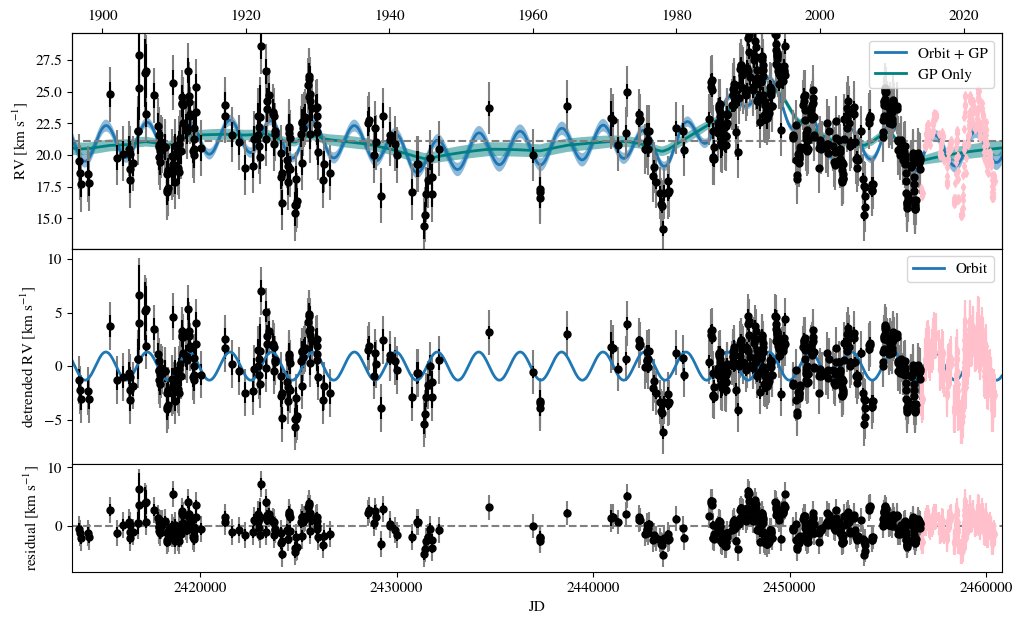

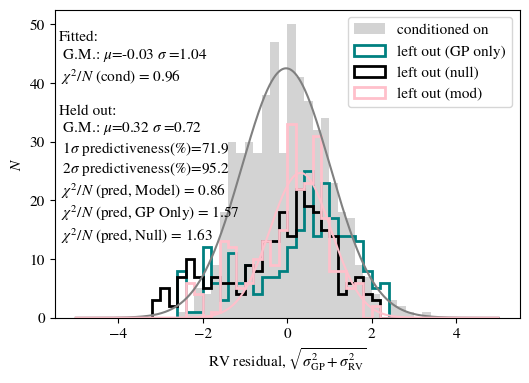

In [210]:
make_drop_sample_plots("radvel/BG_radvel_MLE_Exp4000.0_rv10_p2000.0_2200.0_circ_drop6__iter_0.pkl",name='jit')

# Jitter Example

216000
795 data points


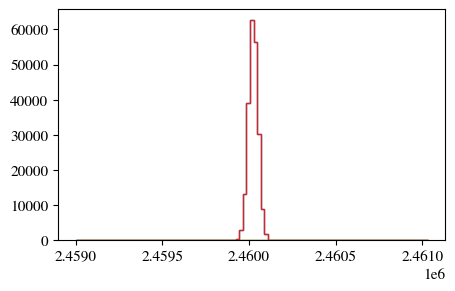

2023.2132174789429
per1 : 2110.0 +/- 2.8
tc1 : 2460023 +/- 27
logk1 : 7.44 +/- 0.065
gamma : 21082 +/- 270
jit : 1843 +/- 56
gp_length : 4000 +/- 1
gp_amp : 627.5 +/- 6.1


In [146]:
gppost = radvel.posterior.load("radvel/BG_radvel_MLE_Exp4000.0_rv10_p2000.0_2200.0_circ___iter_0.pkl")
gpchains = gppost.chains
gplike = gppost.likelihood
print( len(gpchains) )

gpchains['secosw1'] = 0.
gpchains['sesinw1'] = 0.


vfactor=1e3


print(gplike.N,"data points")


# FOLD TC1
tc1med = gpchains['tc1'].quantile(0.5)
sel_p1 = np.abs(gpchains['tc1'] - tc1med) > np.abs(gpchains['tc1'] - gpchains['per1'] - tc1med)
sel_m1 = np.abs(gpchains['tc1'] - tc1med) > np.abs(gpchains['tc1'] + gpchains['per1'] - tc1med)


gpchains.loc[:,'tc1_fold'] = gpchains['tc1'].loc[:]
gpchains.loc[sel_p1,'tc1_fold'] = gpchains['tc1'].loc[sel_p1]-gpchains['per1'].loc[sel_p1]
gpchains.loc[sel_m1,'tc1_fold'] = gpchains['tc1'].loc[sel_m1]+gpchains['per1'].loc[sel_m1]


plt.figure(figsize=(5,3))
mybins = np.linspace(2459000,2459032.625+2000, 100)
plt.hist(gpchains['tc1'],histtype='step',bins=mybins,density=False)

plt.hist(gpchains['tc1'][sel_p1],histtype='step',bins=mybins,density=False)
plt.hist(gpchains['tc1'][sel_m1],histtype='step',bins=mybins,density=False)

plt.hist(gpchains['tc1_fold'],histtype='step',bins=mybins,density=False)

plt.show()

# write over tc1
gpchains.tc1.loc[:] = gpchains.tc1_fold.loc[:]
# drop column
gpchains.drop(['tc1_fold'],axis=1)
 
print(np.mean(Time(gpchains['tc1'],format='jd').jyear) )






quants = gpchains.quantile([0.159, 0.5, 0.841]) # median & 1sigma limits of posterior distributions

for par in gppost.params.keys():
    if gppost.params[par].vary:
        med = quants[par][0.5]
        high = quants[par][0.841] - med
        low = med - quants[par][0.159]
        err = np.mean([high,low])
        err = radvel.utils.round_sig(err)
        med, err, errhigh = radvel.utils.sigfig(med, err)
        print('{} : {} +/- {}'.format(par, med, err))
        
        
#df_synth = gppost.params.basis.to_synth(gpchains)
labels = 'per1 tc1 logk1 gamma'.split()
#gpchains[labels].quantile([0.01,0.05,0.14,0.5,0.84,0.95,0.99]).T

In [147]:
df_synth = gppost.params.basis.to_synth(gpchains)
df_synth['tc1_year'] = Time(df_synth['tc1'],format='jd').jyear
df_synth['M1'] = np.random.uniform(low=10,high=25,size=len(df_synth))
df_synth['M2sini'] = radvel.utils.Msini(df_synth['k1'],df_synth['per1'],df_synth['M1'],df_synth['e1'],Msini_units='jupiter') / 1047.57
df_synth['qsini'] = df_synth['M2sini']/df_synth['M1']
df_synth['a'] = radvel.utils.semi_major_axis(df_synth['per1'],df_synth['M1']+df_synth['M2sini'])
df_synth['log_tdecay']= np.log10( tdecay_calcM1M2a(df_synth['M1']*c.msun,
                                     df_synth['M2sini']*c.msun,
                                     df_synth['a']*c.au,
                                     Pfmdays=416,Teff=3600) )
df_synth['k1_kms'] = df_synth['k1']/1000.
df_synth['logk1_kms'] = np.log(df_synth['k1_kms'])
df_synth['gamma_kms']= df_synth['gamma']/1000
df_synth['jit_kms'] = df_synth['jit']/1000
df_synth['gp_amp_kms']= df_synth['gp_amp']/1000
df_synth['f_msun'] = df_synth['per1']*86400 * (df_synth['k1_kms']*1.e5)**3 / (2*np.pi*c.G) / (1e-4*c.msun)
df_synth['k2_kms'] =  df_synth['k1']/1000. / df_synth['qsini']

labels = 'per1 tc1 tc1_year e1 k1_kms logk1_kms gamma M2sini qsini log_tdecay k2_kms'.split()
df_synth[labels].quantile([0.01,0.05,0.14,0.5,0.84,0.95,0.99]).T

0.01          0.05          0.14          0.50  \
per1        2.103303e+03  2.105288e+03  2.106923e+03  2.109971e+03   
tc1         2.459961e+06  2.459980e+06  2.459995e+06  2.460023e+06   
tc1_year    2.023041e+03  2.023093e+03  2.023135e+03  2.023212e+03   
e1          0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
k1_kms      1.446927e+00  1.519627e+00  1.582187e+00  1.702999e+00   
logk1_kms   3.694417e-01  4.184649e-01  4.588078e-01  5.323909e-01   
gamma       2.045690e+04  2.064714e+04  2.079301e+04  2.108150e+04   
M2sini      4.528946e-01  4.915280e-01  5.373454e-01  6.876946e-01   
qsini       3.164045e-02  3.359231e-02  3.540696e-02  3.967219e-02   
log_tdecay  4.403113e+00  4.434413e+00  4.471705e+00  4.574635e+00   
k2_kms      3.593751e+01  3.664464e+01  3.811372e+01  4.309393e+01   

                    0.84          0.95          0.99  
per1        2.112792e+03  2.114694e+03  2.116623e+03  
tc1         2.460050e+06  2.460068e+06  2.460088e+06  
tc1_year    2.023286e+03  2.023335e+03  2.023389e+03  
e1          0.000000e+00  0.000000e+00  0.000000e+00  
k1_kms      1.813125e+00  1.883954e+00  1.960666e+00  
logk1_kms   5.950519e-01  6.333727e-01  6.732843e-01  
gamma       2.134769e+04  2.152697e+04  2.171508e+04  
M2sini      8.212962e-01  8.846626e-01  9.396332e-01  
qsini       4.470385e-02  4.788885e-02  5.081863e-02  
log_tdecay  4.648769e+00  4.680420e+00  4.708498e+00  
k2_kms      4.693043e+01  4.804719e+01  4.844170e+01

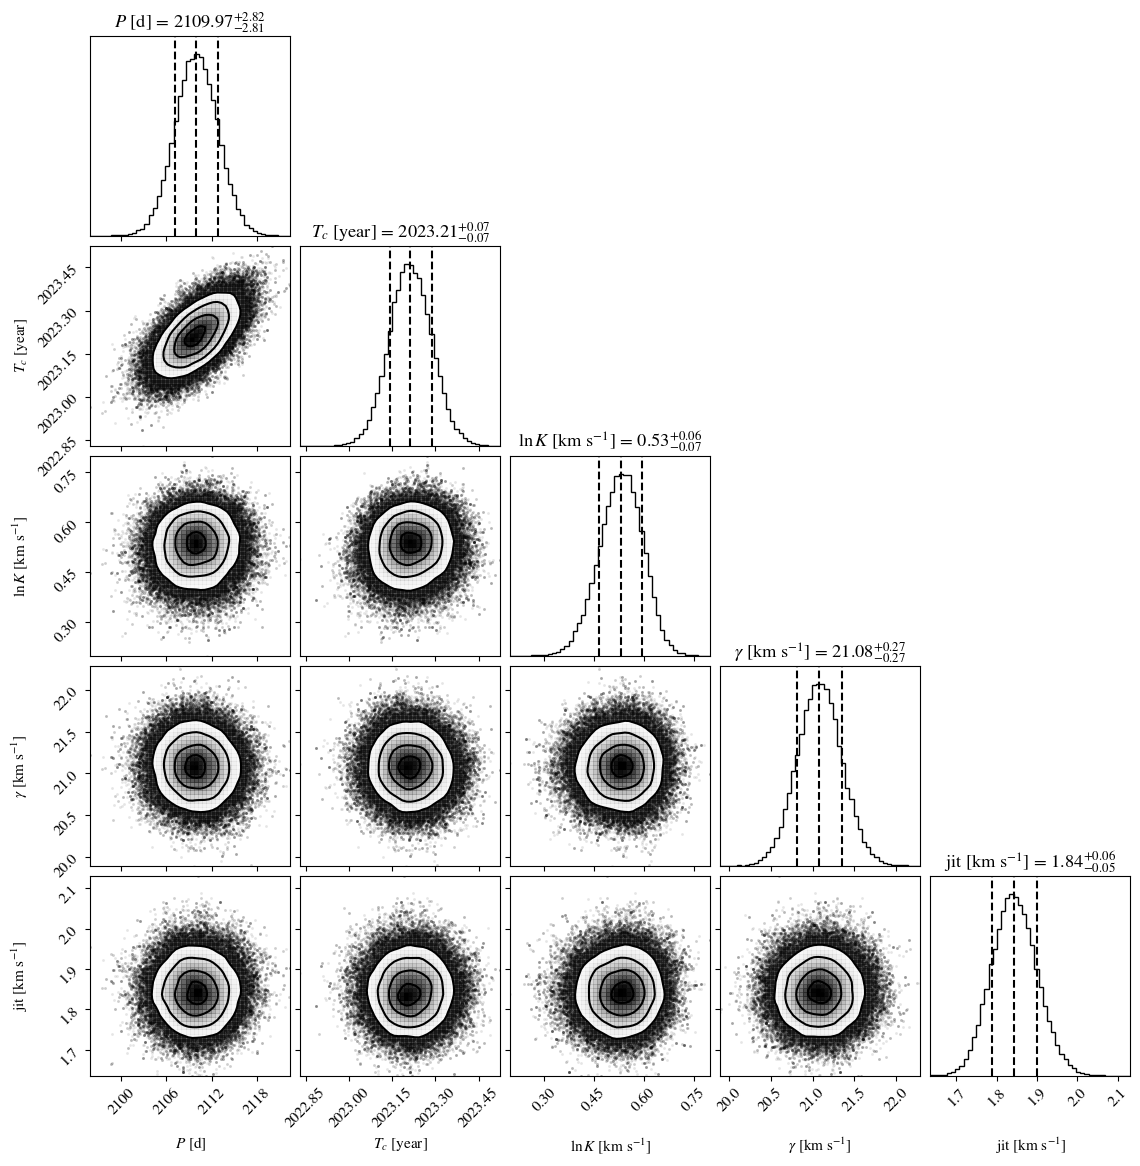

In [148]:
labels = 'per1 tc1_year logk1_kms gamma_kms jit_kms'.split()

fig = corner.corner(
    df_synth[labels],
    plot_datapoints=True,smooth=True,
    show_titles=True,bins=48,
    quantiles=[0.16,0.5,0.84],
    labels=["$P$ [d]", "$T_c$ [year]","$\ln K$ [km s$^{-1}$]", "$\gamma$ [km s$^{-1}$]", "jit [km s$^{-1}$]"]
    )

fig.savefig("figs/corner_mcmc_synth_full_jit.pdf",dpi=300)

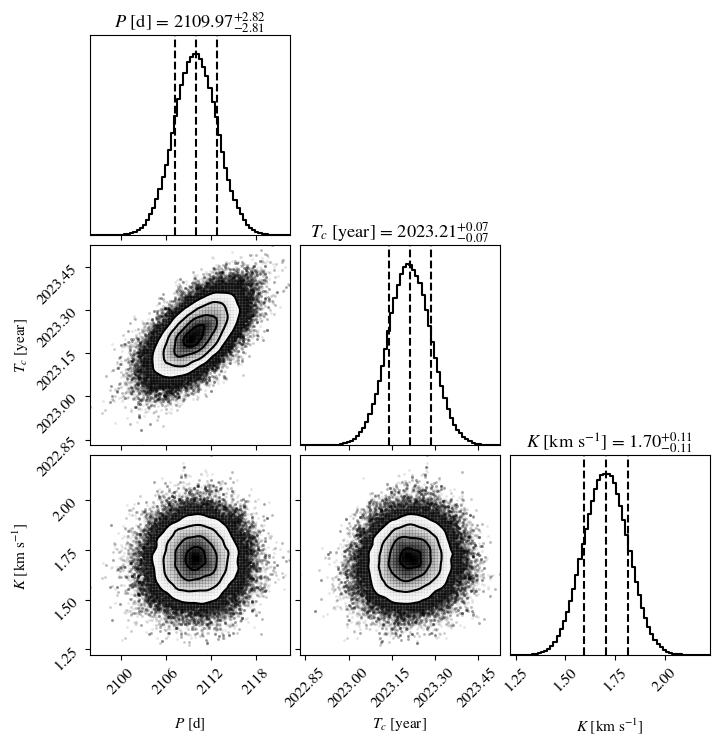

In [149]:
labels = 'per1 tc1_year k1_kms'.split()


fig=corner.corner(
    df_synth[labels],
    plot_datapoints=True,smooth=True,smooth1d=True,
    show_titles=True,bins=64,
    quantiles=[0.16,0.5,0.84],
    labels=["$P$ [d]", "$T_c$ [year]","$K$ [km s$^{-1}$]"]    
    )

fig.savefig("figs/corner_mcmc_synth_jit.pdf",dpi=300)

In [150]:
def initialize_model_from_chain(ind,chain):
    if ind == -99:
        ind = random.randint(0,len(chain)-1)
    index_dict = chain.iloc[ind].to_dict()
    params = radvel.Parameters(1,basis='per tc secosw sesinw logk') 
    for pp in index_dict:
        params[pp] = radvel.Parameter(value=index_dict[pp],vary=False)
    mod = radvel.RVModel(params)
    return mod
    
    
def initialize_model_from_chain_circ(ind,chain):
    if ind == -99:
        ind = random.randint(0,len(chain)-1)
    index_dict = chain.iloc[ind].to_dict()
    params = radvel.Parameters(1,basis='per tc secosw sesinw logk') 
    print('Model index: ',index_dict)
    for pp in index_dict:
        params[pp] = radvel.Parameter(value=index_dict[pp],vary=False)
    params['secosw1'] = radvel.Parameter(value=0.0,vary=False)
    params['sesinw1'] = radvel.Parameter(value=0.0,vary=False)
    mod = radvel.RVModel(params)
    return mod


## NEAR-CIRCULAR SAMPLES, MEDIAN VALUES 
gpcirc = gpchains.copy()
#mymod = initialize_model_from_chain_circ(gpchains.lnprobability.argmax(),gpchains)
#for key in mymod.params.keys():
#    print("{:<13}".format(key),mymod.params[key])

mean_circ_params = radvel.Parameters(1,basis='per tc secosw sesinw logk')

mean_circ_params['per1'] = radvel.Parameter(value = gpcirc.quantile(0.5).per1)
mean_circ_params['tc1']  = radvel.Parameter(value = gpcirc.quantile(0.5).tc1 )
mean_circ_params['secosw1'] = radvel.Parameter(value = 0)
mean_circ_params['sesinw1'] = radvel.Parameter(value = 0)
mean_circ_params['logk1'] = radvel.Parameter(value=gpcirc.quantile(0.5).logk1)
mean_circ_params['gp_amp'] = radvel.Parameter(value=gpcirc.quantile(0.5).gp_amp)
mean_circ_params['gp_length'] = radvel.Parameter(value=gpcirc.quantile(0.5).gp_length)
mean_circ_params['jit'] = radvel.Parameter(value=gpcirc.quantile(0.5).jit)
mean_circ_params['gamma'] = radvel.Parameter(value=gpcirc.quantile(0.5).gamma)

mean_circ_params

print("mean tc1 = ",Time(2459999.132909865,format='jd').jyear)

# MODEL AND LIKE
mymod = radvel.RVModel(mean_circ_params)
for key in mymod.params.keys():
    print("{:<13}".format(key),mymod.params[key])
mylike = radvel.likelihood.GPLikelihood(mymod, gppost.likelihood.x, gppost.likelihood.y, gppost.likelihood.yerr,
                                    hnames=['gp_amp','gp_length'],kernel_name='Exp')

# ARRAYS
t = mylike.x
vel = mylike.y
errvel = mylike.yerr

gpmu,stddev = mylike.predict(t)

### GET FLATTENED ARRAYS
vel_flat = vel - gpmu - mylike.params['gamma'].value
errvel_flat = np.sqrt(errvel**2 + mylike.params['jit'].value**2 + stddev**2)
errvel_flat_nojit = np.sqrt(errvel**2 + stddev**2)

mean tc1 =  2023.1461544417937
per1          Parameter object: value = 2109.9712046159743, vary = True, mcmc scale = None
tc1           Parameter object: value = 2460023.2879506676, vary = True, mcmc scale = None
secosw1       Parameter object: value = 0, vary = True, mcmc scale = None
sesinw1       Parameter object: value = 0, vary = True, mcmc scale = None
logk1         Parameter object: value = 7.440146190326751, vary = True, mcmc scale = None
gp_amp        Parameter object: value = 627.4579676080525, vary = True, mcmc scale = None
gp_length     Parameter object: value = 3999.992663212247, vary = True, mcmc scale = None
jit           Parameter object: value = 1842.7546987026672, vary = True, mcmc scale = None
gamma         Parameter object: value = 21081.503529427988, vary = True, mcmc scale = None


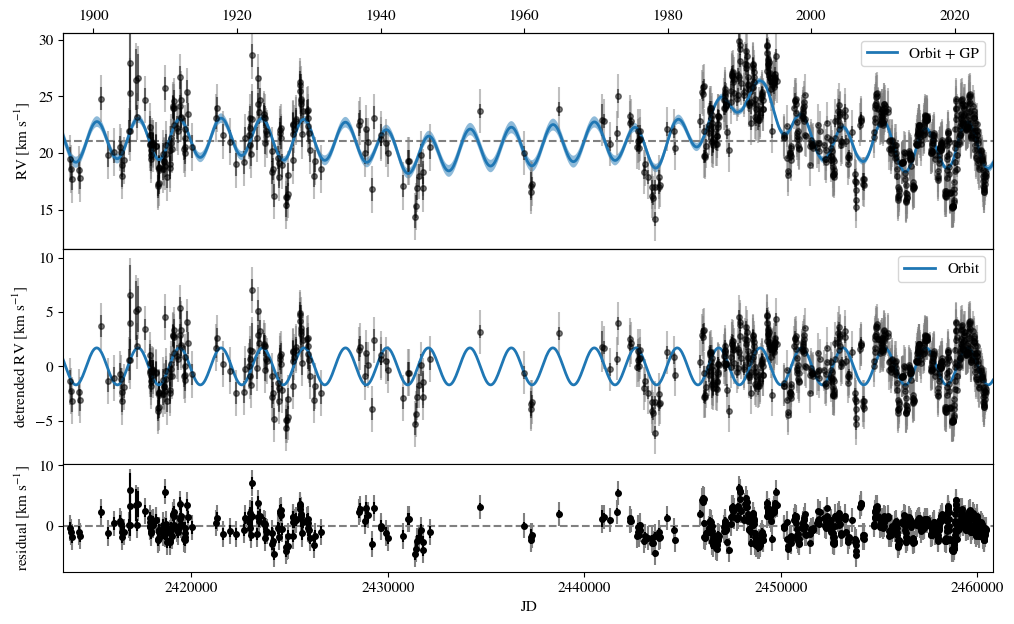

In [151]:
mean_jit = mylike.params['jit'].value #np.mean(gpcirc['jit'])
nlines = 1
yrange = 19

ms = 4


fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(12, 7),
                       gridspec_kw={'height_ratios': [2,2,1],'hspace': 0},sharex=True)




ti = np.linspace(mylike.x[0]-365,mylike.x[-1]+365,1000)
gpmu,stddev = mylike.predict(ti)



axs[0].set_ylabel('RV [km s$^{-1}$]')
axs[0].plot(ti,np.ones_like(ti)*mylike.params['gamma'].value/vfactor,ls='--',color='grey')
axs[0].errorbar(mylike.x,mylike.y/vfactor,np.sqrt(mylike.yerr**2 + mean_jit**2)/vfactor,marker='',
                linestyle='',color='grey',alpha=0.5)
axs[0].errorbar(mylike.x,mylike.y/vfactor,mylike.yerr/vfactor,marker='o',
                linestyle='',color='k',alpha=0.5,markersize=ms)


axs[0].fill_between(ti,
                    (mymod(ti)+gpmu + stddev + mymod.params['gamma'].value)/vfactor,
                    (mymod(ti)+gpmu - stddev + mymod.params['gamma'].value)/vfactor,color='C0',alpha=0.5,label='',edgecolor=None)
axs[0].plot(ti,(mymod(ti)+ gpmu + mymod.params['gamma'].value)/vfactor ,color='C0',alpha=1,lw=2,label='Orbit + GP')

axs[0].legend(loc=0)
axs[0].set_ylim(-yrange/2+mylike.params['gamma'].value/vfactor,
                 yrange/2+mylike.params['gamma'].value/vfactor)
axs[0].set_xlim(ti[0],ti[-1])
ayr = axs[0].twiny()
ayr.set_xlim(Time(ti[0],format='jd').jyear, Time(ti[-1],format='jd').jyear)


axs[1].set_ylabel('detrended RV [km s$^{-1}$]')
axs[1].errorbar(mylike.x,(mylike.y-mylike.predict(mylike.x)[0]-mylike.params['gamma'].value)/vfactor,
                np.sqrt(mylike.yerr**2 + mean_jit**2 + mylike.predict(mylike.x)[1]**2)/vfactor,marker='',linestyle='',color='grey',alpha=0.5)
axs[1].errorbar(mylike.x,(mylike.y-mylike.predict(mylike.x)[0]-mylike.params['gamma'].value)/vfactor,
                mylike.yerr/vfactor,marker='o',linestyle='',color='k',alpha=0.5,markersize=ms)
axs[1].plot(ti,mymod(ti)/vfactor ,color='C0',alpha=1,lw=2,label='Orbit')
axs[1].legend(loc=0)

axs[2].set_ylabel('residual [km s$^{-1}$]')
axs[2].plot(ti,np.zeros_like(ti),ls='--',color='grey')

axs[2].errorbar(mylike.x,(mylike.y-mylike.predict(mylike.x)[0]-mylike.params['gamma'].value-mylike.model(mylike.x))/vfactor,
                np.sqrt(mylike.yerr**2 + mean_jit**2 + mylike.predict(mylike.x)[1]**2)/vfactor,marker='',linestyle='',color='grey')
axs[2].errorbar(mylike.x,(mylike.y-mylike.predict(mylike.x)[0]-mylike.params['gamma'].value-mylike.model(mylike.x))/vfactor,
                mylike.yerr/vfactor,marker='o',linestyle='',color='k',markersize=ms)
#axs[1].set_ylim(-yrange/2,yrange/2)
axs[2].set_xticks([2420000,2430000,2440000,2450000,2460000])
axs[2].xaxis.set_major_formatter(ticker.FormatStrFormatter("%i"))
axs[2].set_xlabel('JD')

"""
mylw = 1
myalpha = 0.25
for i in range(nlines):
    mymod = initialize_model_from_chain(-99,gpcirc)
    mylike = radvel.likelihood.GPLikelihood(mymod, mylike.x, mylike.y, mylike.yerr,
                                        hnames=['gp_amp','gp_length'],kernel_name='SqExp')
    gpmu,stddev = mylike.predict(ti)
    
    axs[0].plot(ti,(gpmu + mymod.params['gamma'].value)/vfactor,color='C1',alpha=myalpha,lw=mylw)
    axs[0].plot(ti,(mymod(ti)+ gpmu + mymod.params['gamma'].value)/vfactor ,color='C0',alpha=myalpha,lw=mylw)
    
"""

plt.subplots_adjust(hspace=0)


#rva = Table.read('RVs/BG_rv10.csv')
#axs[0].errorbar(rva['JD'],rva['RV'],rva['RV_err'],color='r',marker='x',linestyle='')

fig.savefig("figs/RV_timeseries_model_jit.pdf",bbox_inches='tight',dpi=300)

# Eccentric + Jitter

224000
795 data points


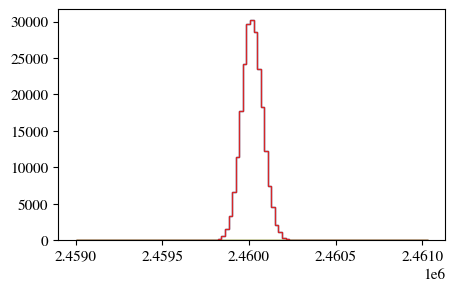

2023.1994807430776
per1 : 2110.4 +/- 2.7
tc1 : 2460017 +/- 60
secosw1 : 0.04 +/- 0.11
sesinw1 : -0.457 +/- 0.086
logk1 : 7.471 +/- 0.066
gamma : 21065 +/- 260
jit : 1828 +/- 55
gp_length : 3999.96 +/- 0.99
gp_amp : 627.3 +/- 6.2


In [152]:
gppost = radvel.posterior.load("radvel/BG_radvel_MLE_Exp4000.0_rv10_p2000.0_2200.0_e0.6___iter_0.pkl")
gpchains = gppost.chains
gplike = gppost.likelihood
print( len(gpchains) )

#gpchains['secosw1'] = 0.
#gpchains['sesinw1'] = 0.


vfactor=1e3


print(gplike.N,"data points")


# FOLD TC1
tc1med = gpchains['tc1'].quantile(0.5)
sel_p1 = np.abs(gpchains['tc1'] - tc1med) > np.abs(gpchains['tc1'] - gpchains['per1'] - tc1med)
sel_m1 = np.abs(gpchains['tc1'] - tc1med) > np.abs(gpchains['tc1'] + gpchains['per1'] - tc1med)


gpchains.loc[:,'tc1_fold'] = gpchains['tc1'].loc[:]
gpchains.loc[sel_p1,'tc1_fold'] = gpchains['tc1'].loc[sel_p1]-gpchains['per1'].loc[sel_p1]
gpchains.loc[sel_m1,'tc1_fold'] = gpchains['tc1'].loc[sel_m1]+gpchains['per1'].loc[sel_m1]


plt.figure(figsize=(5,3))
mybins = np.linspace(2459000,2459032.625+2000, 100)
plt.hist(gpchains['tc1'],histtype='step',bins=mybins,density=False)

plt.hist(gpchains['tc1'][sel_p1],histtype='step',bins=mybins,density=False)
plt.hist(gpchains['tc1'][sel_m1],histtype='step',bins=mybins,density=False)

plt.hist(gpchains['tc1_fold'],histtype='step',bins=mybins,density=False)

plt.show()

# write over tc1
gpchains.tc1.loc[:] = gpchains.tc1_fold.loc[:]
# drop column
gpchains.drop(['tc1_fold'],axis=1)
 
print(np.mean(Time(gpchains['tc1'],format='jd').jyear) )






quants = gpchains.quantile([0.159, 0.5, 0.841]) # median & 1sigma limits of posterior distributions

for par in gppost.params.keys():
    if gppost.params[par].vary:
        med = quants[par][0.5]
        high = quants[par][0.841] - med
        low = med - quants[par][0.159]
        err = np.mean([high,low])
        err = radvel.utils.round_sig(err)
        med, err, errhigh = radvel.utils.sigfig(med, err)
        print('{} : {} +/- {}'.format(par, med, err))
        
        
#df_synth = gppost.params.basis.to_synth(gpchains)
labels = 'per1 tc1 logk1 gamma'.split()
#gpchains[labels].quantile([0.01,0.05,0.14,0.5,0.84,0.95,0.99]).T

In [153]:
df_synth = gppost.params.basis.to_synth(gpchains)
df_synth['tc1_year'] = Time(df_synth['tc1'],format='jd').jyear
df_synth['M1'] = np.random.uniform(low=10,high=25,size=len(df_synth))
df_synth['M2sini'] = radvel.utils.Msini(df_synth['k1'],df_synth['per1'],df_synth['M1'],df_synth['e1'],Msini_units='jupiter') / 1047.57
df_synth['qsini'] = df_synth['M2sini']/df_synth['M1']
df_synth['a'] = radvel.utils.semi_major_axis(df_synth['per1'],df_synth['M1']+df_synth['M2sini'])
df_synth['log_tdecay']= np.log10( tdecay_calcM1M2a(df_synth['M1']*c.msun,
                                     df_synth['M2sini']*c.msun,
                                     df_synth['a']*c.au,
                                     Pfmdays=416,Teff=3600) )
df_synth['k1_kms'] = df_synth['k1']/1000.
df_synth['logk1_kms'] = np.log(df_synth['k1_kms'])
df_synth['gamma_kms']= df_synth['gamma']/1000
df_synth['jit_kms'] = df_synth['jit']/1000
df_synth['gp_amp_kms']= df_synth['gp_amp']/1000
df_synth['f_msun'] = df_synth['per1']*86400 * (df_synth['k1_kms']*1.e5)**3 / (2*np.pi*c.G) / (1e-4*c.msun)
df_synth['k2_kms'] =  df_synth['k1']/1000. / df_synth['qsini']

labels = 'per1 tc1 tc1_year e1 k1_kms logk1_kms gamma M2sini qsini log_tdecay k2_kms'.split()
df_synth[labels].quantile([0.01,0.05,0.14,0.5,0.84,0.95,0.99]).T

0.01          0.05          0.14          0.50  \
per1        2.104173e+03  2.105992e+03  2.107463e+03  2.110365e+03   
tc1         2.459881e+06  2.459921e+06  2.459954e+06  2.460017e+06   
tc1_year    2.022823e+03  2.022933e+03  2.023023e+03  2.023196e+03   
e1          3.579509e-02  9.429628e-02  1.395121e-01  2.222088e-01   
k1_kms      1.491640e+00  1.569709e+00  1.633327e+00  1.755944e+00   
logk1_kms   3.998759e-01  4.508905e-01  4.906189e-01  5.630066e-01   
gamma       2.045084e+04  2.062471e+04  2.078174e+04  2.106460e+04   
M2sini      4.548443e-01  4.930668e-01  5.392993e-01  6.895797e-01   
qsini       3.180442e-02  3.375947e-02  3.551385e-02  3.977807e-02   
log_tdecay  4.401679e+00  4.433413e+00  4.470712e+00  4.573889e+00   
k2_kms      3.663392e+01  3.760859e+01  3.917756e+01  4.430283e+01   

                    0.84          0.95          0.99  
per1        2.113036e+03  2.114792e+03  2.116533e+03  
tc1         2.460079e+06  2.460120e+06  2.460165e+06  
tc1_year    2.023364e+03  2.023477e+03  2.023599e+03  
e1          2.937001e-01  3.392236e-01  3.830000e-01  
k1_kms      1.873510e+00  1.948291e+00  2.025027e+00  
logk1_kms   6.278138e-01  6.669524e-01  7.055828e-01  
gamma       2.132401e+04  2.149924e+04  2.168334e+04  
M2sini      8.244192e-01  8.875997e-01  9.436811e-01  
qsini       4.488905e-02  4.805546e-02  5.105534e-02  
log_tdecay  4.648092e+00  4.679204e+00  4.706977e+00  
k2_kms      4.823787e+01  4.958129e+01  5.078634e+01

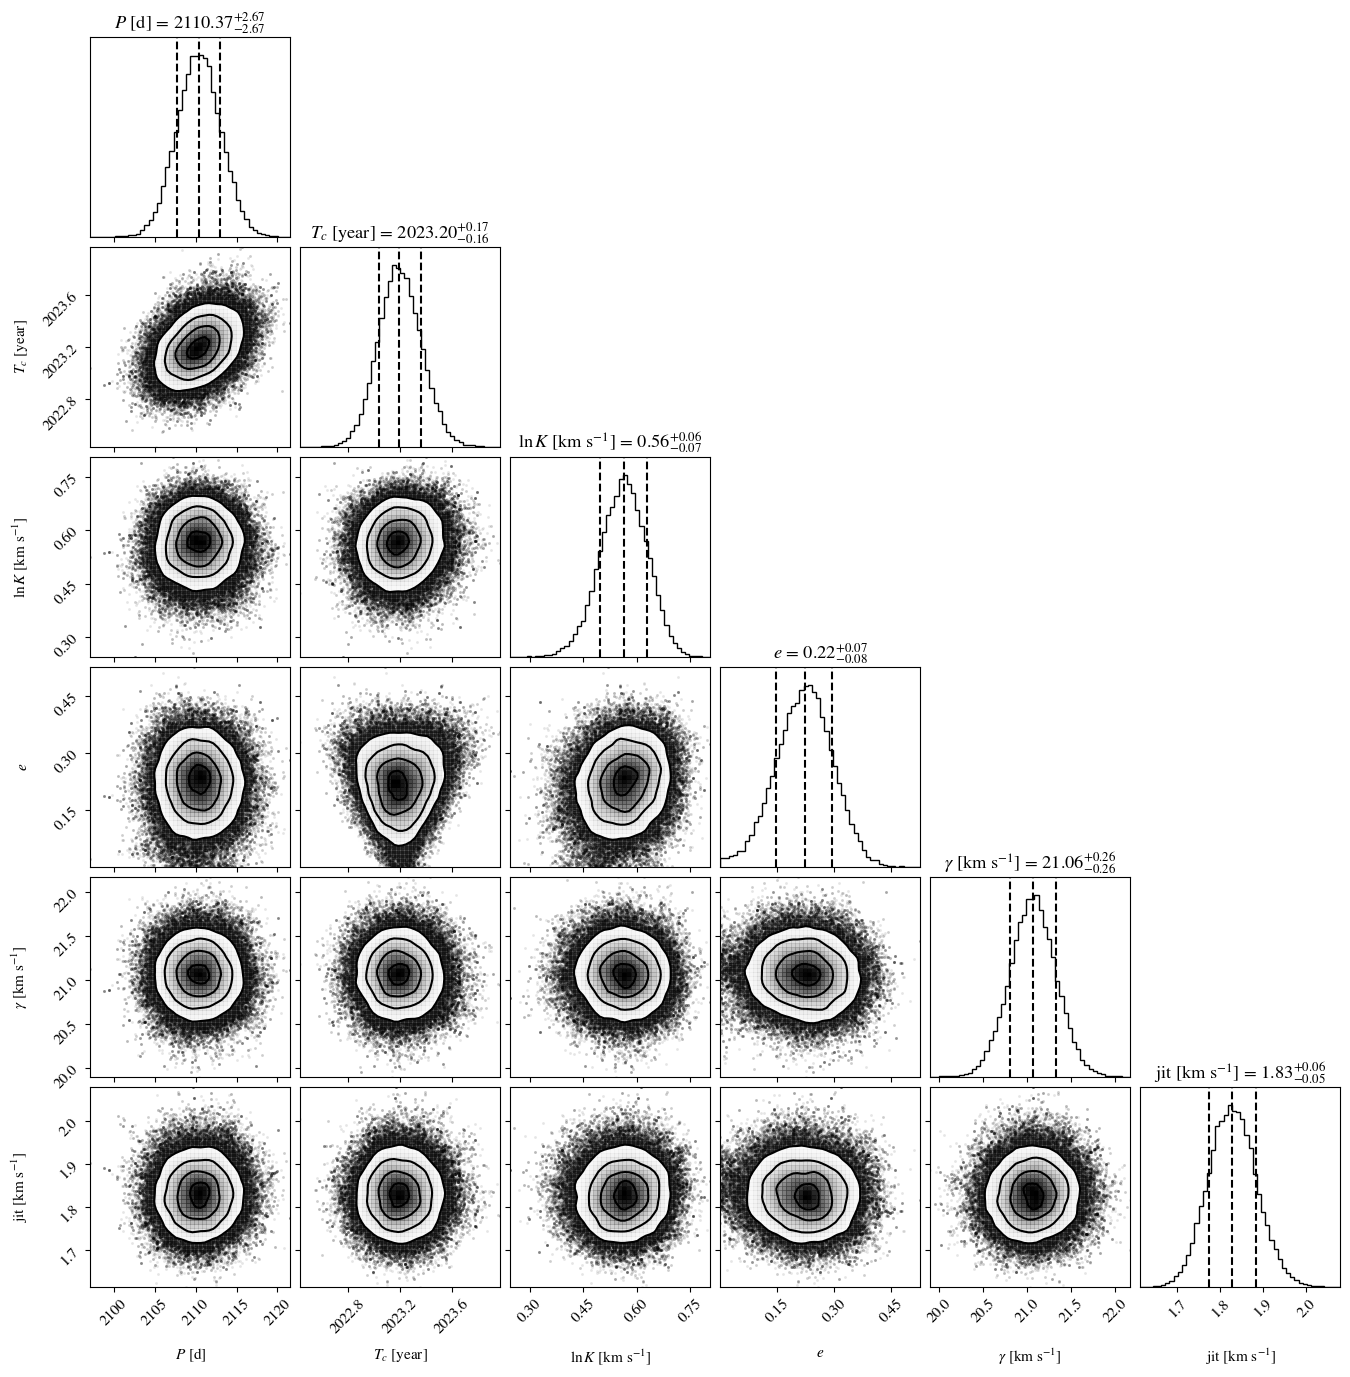

In [154]:
labels = 'per1 tc1_year logk1_kms e1 gamma_kms jit_kms'.split()

fig = corner.corner(
    df_synth[labels],
    plot_datapoints=True,smooth=True,
    show_titles=True,bins=48,
    quantiles=[0.16,0.5,0.84],
    labels=["$P$ [d]", "$T_c$ [year]","$\ln K$ [km s$^{-1}$]","$e$","$\gamma$ [km s$^{-1}$]", "jit [km s$^{-1}$]"]
    )

#fig.savefig("figs/corner_mcmc_synth_full_jit.pdf",dpi=300)

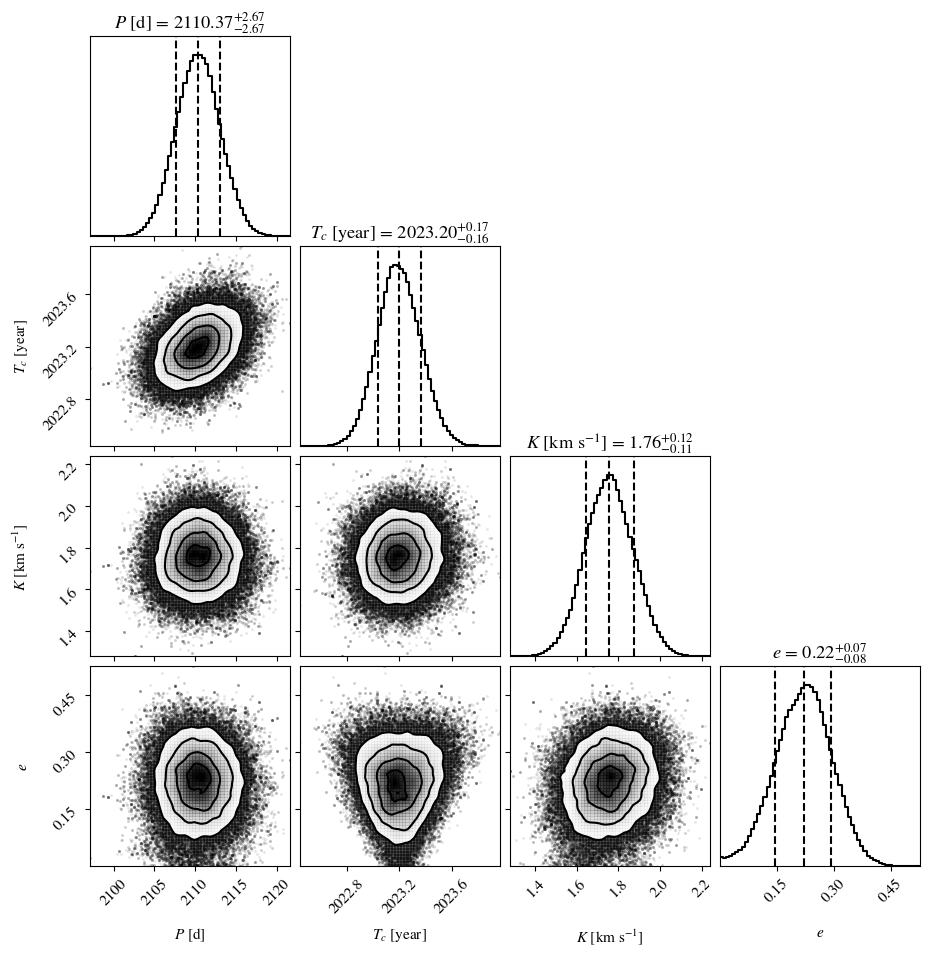

In [155]:
labels = 'per1 tc1_year k1_kms e1'.split()


fig=corner.corner(
    df_synth[labels],
    plot_datapoints=True,smooth=True,smooth1d=True,
    show_titles=True,bins=64,
    quantiles=[0.16,0.5,0.84],
    labels=["$P$ [d]", "$T_c$ [year]","$K$ [km s$^{-1}$]","$e$"]    
    )

#fig.savefig("figs/corner_mcmc_synth_jit.pdf",dpi=300)

## Isochrones

Reading in: ../MIST_v1.2_vvcrit0.0_basic_isos/MIST_v1.2_feh_p0.00_afe_p0.0_vvcrit0.0_basic.iso


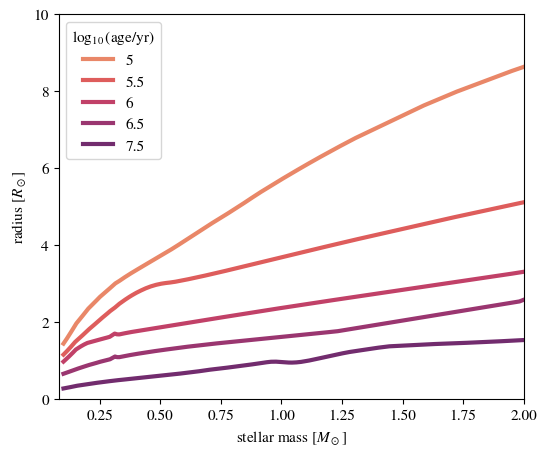

In [60]:
import read_mist_models
iso = read_mist_models.ISO('../MIST_v1.2_vvcrit0.0_basic_isos/MIST_v1.2_feh_p0.00_afe_p0.0_vvcrit0.0_basic.iso')


agelist = [5,5.5,6,6.5,7.5]

mycm = sns.color_palette("flare", len(agelist))

plt.figure(figsize=(6,5))

for i,myage in enumerate(agelist):
    age_ind = iso.age_index(myage) #returns the index for the desired age
    sel = iso.isos[age_ind]['phase']<1
    mass = iso.isos[age_ind][sel]['star_mass']
    radius = 10**iso.isos[age_ind][sel]['log_R']
    plt.plot(mass ,radius, color=mycm[i], lw=3,label=myage ) 
    
plt.legend(loc='upper left',title=r'$\log_{10}$(age/yr)',frameon=True)
    

plt.xlim(0.08,2)
plt.ylim(0,10)
plt.xlabel(r'stellar mass $[M_\odot]$')
plt.ylabel(r'radius [$R_\odot$]')

plt.subplots_adjust(hspace=0.05)
plt.savefig('figs/isochrones.pdf',bbox_inches='tight')

In [182]:
# diameter BG in radians
0.5 * 42.28*4.84814e-9 * 1/5.4e-3 * c.pc / c.rsun

842.0536960502516

In [185]:
4*np.pi*(842*c.rsun)**2 * c.sigmaSB * 3600**4 / 3.83e33 / 1e5

1.0716714609808704

In [450]:
(2*np.pi * (842*c.rsun)**1.5 / (416*86400 *c.G**0.5 *1.5))**2 / c.msun

20.54800981193803

In [212]:
0.159 * 2* 1.3e5 * 86400e3  / c.rsun  # semi-amplitude rsun

51.355514018691586

In [213]:
0.159 * 2 * 1.3e5 * 86400e3  / (185*c.pc) / 4.84814e-9 # semi-amplitude (mas)

1.2905855217562632

In [299]:
# Position and Velocity

df_pos = pd.read_csv("/Users/morganmacleod/Dropbox/Betelgeuse_ORB/betelgeuse_present_day_samples.csv")
plus = df_pos[['U_lsr','V_lsr','W_lsr']].quantile(0.84)-df_pos[['U_lsr','V_lsr','W_lsr']].quantile(0.5)
minus = df_pos[['U_lsr','V_lsr','W_lsr']].quantile(0.16)-df_pos[['U_lsr','V_lsr','W_lsr']].quantile(0.5)
med = df_pos[['U_lsr','V_lsr','W_lsr']].quantile(0.5)

In [303]:
print (med,"\n",plus,"\n",minus)

U_lsr   -10.787661
V_lsr     1.430657
W_lsr    24.986182
Name: 0.5, dtype: float64 
 U_lsr    0.459483
V_lsr    0.727742
W_lsr    3.573027
dtype: float64 
 U_lsr   -0.490824
V_lsr   -1.003087
W_lsr   -2.229007
dtype: float64


In [304]:
df_pos[['U_lsr','V_lsr','W_lsr']].quantile((0.16,0.5,0.84))

U_lsr     V_lsr      W_lsr
0.16 -11.278485  0.427570  22.757175
0.50 -10.787661  1.430657  24.986182
0.84 -10.328178  2.158399  28.559209

In [305]:
np.linalg.norm(med)

27.253067440560205

In [453]:
1816*(20.5/17.5)**(1/3) 

1914.348996542969

In [454]:
1914/842

2.2731591448931114

In [312]:
842*(185-26)/185 - 842

-118.33513513513515

In [457]:
20.5*((185+37)/185)**3 - 20.5

14.923999999999992

In [461]:
0.031 * (20.5/17.5)**(-1/3)  * 20.5

0.602851414284478

In [462]:
0.031 * (20.5/17.5)**(-1/3)  * 20.5*((185-26)/185)**3 - 0.602, 0.031 * (20.5/17.5)**(-1/3)  * 20.5*((185+37)/185)**3 - 0.602

(-0.21927531713902576, 0.43972724388357787)

Reading in: ../MIST_v1.2_vvcrit0.0_basic_isos/MIST_v1.2_feh_p0.00_afe_p0.0_vvcrit0.0_basic.iso


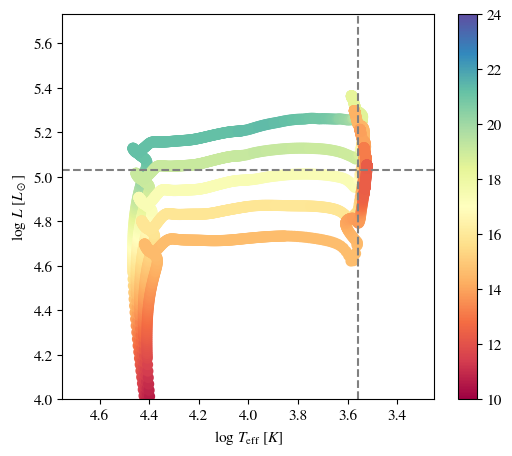

In [61]:
iso = read_mist_models.ISO('../MIST_v1.2_vvcrit0.0_basic_isos/MIST_v1.2_feh_p0.00_afe_p0.0_vvcrit0.0_basic.iso')


agelist = [np.log10(8e6),np.log10(9e6),np.log10(1e7),np.log10(1.1e7),np.log10(1.2e7)]

mycm = sns.color_palette("flare", len(agelist))

plt.figure(figsize=(6,5))

for i,myage in enumerate(agelist):
    age_ind = iso.age_index(myage) #returns the index for the desired age
    sel = iso.isos[age_ind]['phase']<6
    mass = iso.isos[age_ind][sel]['star_mass']
    #radius = 10**iso.isos[age_ind][sel]['log_R']
    lum = iso.isos[age_ind][sel]['log_L']
    teff = iso.isos[age_ind][sel]['log_Teff']
    plt.scatter(teff ,lum, c=mass, lw=3,label=myage,vmin=10,vmax=24 , cmap='Spectral') 
    
#plt.legend(loc='upper left',title=r'$\log_{10}$(age/yr)',frameon=True)
plt.colorbar()

plt.xlim(4.75,3.25)
plt.ylim(4,)
plt.xlabel(r'log $T_{\rm eff}$ $[K]$')
plt.ylabel(r'log $L$ [$L_\odot$]')
plt.axvline(np.log10(3600),color='grey',ls='--')
plt.axhline(np.log10(1.07e5),color='grey',ls='--')

plt.subplots_adjust(hspace=0.05)


In [427]:
(2*np.pi * (842*c.rsun)**1.5 / (1.5*416*86400 *c.G**0.5))**2 / c.msun

20.54800981193803

In [382]:
Time(59858,format='mjd').jyear

2022.7611225188227

In [384]:
276/365.25

0.75564681724846

In [386]:
np.sqrt(c.G*22*c.msun/(9*c.au)) / 1e5

46.573060882875204

In [387]:
90/4

22.5

In [388]:
90/8 

11.25

In [389]:
0.25*np.pi

0.7853981633974483

In [390]:
1.8*9

16.2

In [391]:
1.8*2.3

4.14

In [469]:
(1.07e5*3.83e33/(20.5*c.msun*(842*c.rsun)**2))**(-1/3) / 86400

808.7751003970881

In [414]:
20.5*0.07

1.435

In [415]:
20.5*0.03

0.615

In [463]:
43*(20.5/17.5)**(1/3)

45.32874826616061

In [465]:
2*c.G*0.6*c.msun/(45e5)**2 / c.rsun

113.10454828660436

In [466]:
1914/842

2.2731591448931114

In [468]:
0.03*2.27**-3

0.002564741995931806

In [472]:
1/gamma_calc(1.07e5*3.83e33,20.5*c.msun,842*c.rsun) / 86400

808.7751003970881

In [476]:
tdecay_calcM1M2a(20.5*c.msun,0.6*c.msun,1914*c.rsun) / 1e4

5.273886424602853

## root find for mass...

Reading in: ../MIST_v1.2_feh_p0.00_afe_p0.0_vvcrit0.0_EEPS/01000M.track.eep
Reading in: ../MIST_v1.2_feh_p0.00_afe_p0.0_vvcrit0.0_EEPS/01100M.track.eep
Reading in: ../MIST_v1.2_feh_p0.00_afe_p0.0_vvcrit0.0_EEPS/01200M.track.eep
Reading in: ../MIST_v1.2_feh_p0.00_afe_p0.0_vvcrit0.0_EEPS/01300M.track.eep
Reading in: ../MIST_v1.2_feh_p0.00_afe_p0.0_vvcrit0.0_EEPS/01400M.track.eep
Reading in: ../MIST_v1.2_feh_p0.00_afe_p0.0_vvcrit0.0_EEPS/01500M.track.eep
Reading in: ../MIST_v1.2_feh_p0.00_afe_p0.0_vvcrit0.0_EEPS/01600M.track.eep
Reading in: ../MIST_v1.2_feh_p0.00_afe_p0.0_vvcrit0.0_EEPS/01700M.track.eep
Reading in: ../MIST_v1.2_feh_p0.00_afe_p0.0_vvcrit0.0_EEPS/01800M.track.eep
Reading in: ../MIST_v1.2_feh_p0.00_afe_p0.0_vvcrit0.0_EEPS/01900M.track.eep
Reading in: ../MIST_v1.2_feh_p0.00_afe_p0.0_vvcrit0.0_EEPS/02000M.track.eep
Reading in: ../MIST_v1.2_feh_p0.00_afe_p0.0_vvcrit0.0_EEPS/02200M.track.eep
Reading in: ../MIST_v1.2_feh_p0.00_afe_p0.0_vvcrit0.0_EEPS/02400M.track.eep
Reading in: 

<Table length=18>
       mass              log_L       
     float64            float64      
------------------ ------------------
 9.999994416059506   4.26368738495261
10.999992929549098  4.352714209844083
11.999991621791006  4.477007361311329
12.999989885292297  4.603241516782608
13.999987683810893 4.6651303819780905
14.999986224171021  4.773909590067151
15.999983647337698  4.834411781305422
16.999981339014212  4.919572346705017
17.999977850510348  4.992126985896208
18.999975342986048  5.054462342902457
 19.99997185534839  5.109205711494213
21.999965513473448  5.206305232982512
23.999955427812843   5.30444395802463
 25.99994708699258  5.372710800772035
27.999939887201453  5.430557273130662
 29.99992887247309  5.488990034106843
31.999919396806654  5.539572754675349
33.999916845001245  5.583475607816411

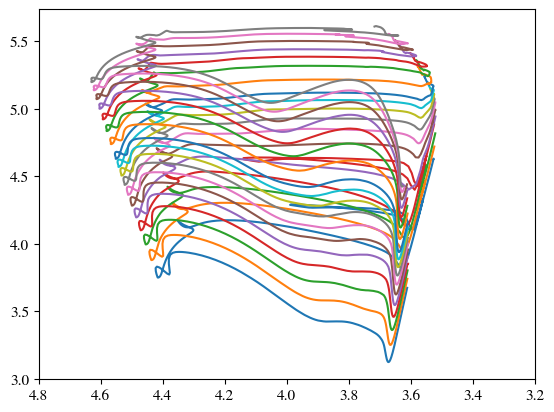

In [62]:
from glob import glob
filelist = sorted(glob("../MIST_v1.2_feh_p0.00_afe_p0.0_vvcrit0.0_EEPS/0[1-3][0-9]00M.track.eep"))[0:-2]

ltab = []
for i,fn in enumerate(filelist):
    eep = read_mist_models.EEP(fn)
    plt.plot(eep.eeps['log_Teff'],eep.eeps['log_L'])
    #plt.colorbar()
    ltab.append([eep.eeps['star_mass'][0], np.mean(eep.eeps['log_L'][eep.eeps['phase']==3])]) # phase 3 is CHeB
    #ltab.append([eep.eeps['star_mass'][0], np.min(eep.eeps['log_L'][eep.eeps['phase']==3]), np.max(eep.eeps['log_L'][eep.eeps['phase']==5] ) ])
plt.xlim(4.8,3.2)
    
ltab = Table(np.array(ltab),names=['mass','log_L'])

ltab


In [807]:
10**5.8/1e5

6.30957344480193

In [808]:
1.07*(220/185)**2

1.5131628926223524

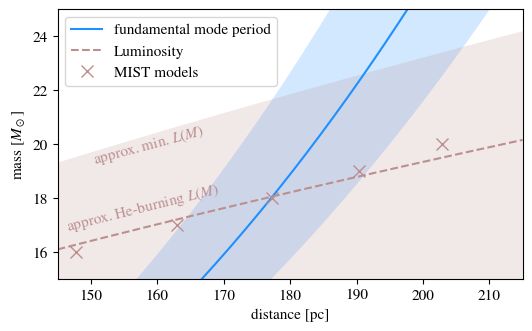

In [66]:
## THIS WOULD BE A COOL PLOT!! 

from scipy.optimize import root_scalar

def Mfm(d):
    return 20.5*(d/185)**3

def Mlum(d):
    return 18.5*(d/185)**(2/3.5) # emperical scaling = 2.9

def root_distance(d):
    return Mfm(d)-Mlum(d)

def dist(L):
    return 185*np.sqrt(L/1.07e5)

#root_scalar(root_distance,x0=200,x1=201)
fmc='DodgerBlue'
lc = 'RosyBrown'

plt.figure(figsize=(6,3.5))

xp = np.linspace(145,215,1000)
plt.plot(xp,Mfm(xp),label='fundamental mode period',color=fmc)
plt.plot(xp,Mlum(xp),label='Luminosity',color=lc,ls='--')

plt.fill_between(xp,Mfm(xp)/1.2,Mfm(xp)*1.2,alpha=0.2,color=fmc,edgecolor=None)
plt.fill_between(xp,0,Mlum(xp)*1.2,alpha=0.2,color=lc,edgecolor=None)

plt.plot(dist(10**ltab['log_L']),ltab['mass'],'x',label='MIST models',color='RosyBrown',markersize=8)
#plt.plot(dist(10**ltab['log_L_max']),ltab['mass'],'rx-')

#plt.semilogy()
plt.legend(loc='upper left')
plt.ylim(15,25)
plt.xlim(xp[0],xp[-1])
plt.ylabel('mass [$M_\odot$]')
plt.xlabel('distance [pc]')

plt.annotate(r'approx. min. $L(M)$',xy=(150,19.3),rotation=15,color=lc)
plt.annotate(r'approx. He-burning $L(M)$',xy=(146,16.8),rotation=14,color=lc)

plt.savefig('figs/mass-distance.pdf',bbox_inches='tight')

## REDO WITH MIST TRACKS? 

In [827]:
(177.3/185)*842

806.9545945945947

In [837]:
1.07e5*((177.3+15)/185)**2 /1e4  - 9.8

1.7610928560993422

In [839]:
18*0.01

0.18

# Spectrum Fig

Lacc =  0.0031348791467961856 TeffAcc =  1933.2874927722548
Lacc =  0.10449597155987285 TeffAcc =  26819.797861226467


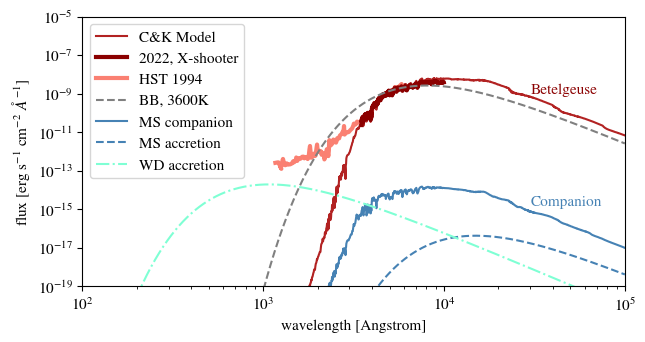

In [804]:
import specutils as su
from astropy.convolution import convolve, Gaussian1DKernel

def BBlam(T,lam):
    """ erg s^-1 cm^-1 Sr^-1 """
    return 2*c.h*c.c**2 / lam**5 / (np.exp(c.h*c.c/(lam*c.kB*T))-1)

spo = su.Spectrum1D.read("spectra/xsl_spectrum_X0036_vis_nlc.fits")
spu = su.Spectrum1D.read("spectra/xsl_spectrum_X0036_uvb_nlc.fits")
sp22 = su.Spectrum1D.read("spectra/xsl_spectrum_X0036_merged_ncl_ncge.fits")
sb = Table.read("spectra/ssap_3500_0.0.dat.txt",names=['lambda','flux'],format='ascii')
bguv = Table.read('spectra/bgUV1994.csv',names=['lambda','flux'],format='ascii')

sc = Table.read("spectra/models_1700015373/Kurucz/fp00k2odfnew.pck.teff=3750..logg=4.00000.dat.txt",names=['lambda','flux'],format='ascii')
#scl = Table.read("spectra/models_1700015373/Kurucz/fp00k2odfnew.pck.teff=3500..logg=4.00000.dat.txt",names=['lambda','flux'],format='ascii')
#scu = Table.read("spectra/models_1700015373/Kurucz/fp00k2odfnew.pck.teff=4000..logg=4.00000.dat.txt",names=['lambda','flux'],format='ascii')

plt.figure(figsize=(7,3.5))

dbg = 185*c.pc
fnorm = ((842*c.rsun)/dbg)**2 
kern = Gaussian1DKernel(30)
fillcolor = 'SteelBlue'


plt.plot(sb['lambda'],fnorm*sb['flux'],color='FireBrick',label='C&K Model')
plt.plot(sp22.wavelength,200*convolve(sp22.flux,kern),label='2022, X-shooter',color='DarkRed',lw=3 )
plt.plot(bguv['lambda'],bguv['flux']*(130/175)**2,label='HST 1994',zorder=0,lw=3,color='salmon')

plt.annotate('Betelgeuse',(3e4,1e-9),color='DarkRed')


wav = np.logspace(1,5,10000)*1e-7 # cm
plt.plot(wav*1e8,fnorm*1e-8*BBlam(3600,wav),'--',label='BB, 3600K',color='grey',)


plt.plot(sc['lambda'],(1*c.rsun/dbg)**2 *sc['flux'],color=fillcolor,label='MS companion')
#plt.fill_between(sc['lambda'],(0.671*c.rsun/dbg)**2 *scl['flux'],
#                 (1.154*c.rsun/dbg)**2 *scu['flux'],
#                 color=fillcolor)

plt.annotate('Companion',(3e4,1.5e-15),color=fillcolor)

Racc = 0.5*c.rsun
Macc = 0.5*c.msun
mdot = 1e-9*c.msun/c.yr
Lacc = 0.1 * c.G*Macc*mdot/Racc
Tacc = ( Lacc/(4*np.pi*Racc**2 * c.sigmaSB ))**0.25
print("Lacc = ", Lacc/3.84e33, "TeffAcc = ",Tacc ) 

plt.plot(wav*1e8,1.e-8*(Racc/dbg)**2 * BBlam(Tacc,wav) ,"--",label='MS accretion',color=fillcolor)

Racc = 0.015*c.rsun
Macc = 0.5*c.msun
mdot = 1e-9*c.msun/c.yr
Lacc = 0.1 * c.G*Macc*mdot/Racc
Tacc = ( Lacc/(4*np.pi*Racc**2 * c.sigmaSB ))**0.25
print("Lacc = ", Lacc/3.84e33, "TeffAcc = ",Tacc ) 

plt.plot(wav*1e8,1.e-8*(Racc/dbg)**2 * BBlam(Tacc,wav) ,"-.",label='WD accretion',color='Aquamarine')


plt.legend()
plt.loglog()
plt.ylim(1.e-19,1e-5)
plt.xlim(100,1e5)

plt.xlabel('wavelength [Angstrom]')
plt.ylabel('flux [erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$]')
plt.savefig('figs/spectra_acc.pdf',bbox_inches='tight')

# MESA

In [479]:
(2*np.pi/1.413)**2 * (842*c.rsun)**3 / (c.G*(416*86400)**2) / c.msun

23.156235560534373

In [487]:
(416/455)**(1/3) * 842

817.2207830786311

STAR/BINARY HISTORY:
['model_number', 'star_age', 'star_mass', 'log_abs_mdot', 'log_dt', 'num_zones', 'mass_conv_core', 'conv_mx1_top', 'conv_mx1_bot', 'conv_mx2_top', 'conv_mx2_bot', 'mx1_top', 'mx1_bot', 'mx2_top', 'mx2_bot', 'epsnuc_M_1', 'epsnuc_M_2', 'epsnuc_M_3', 'epsnuc_M_4', 'epsnuc_M_5', 'epsnuc_M_6', 'epsnuc_M_7', 'epsnuc_M_8', 'he_core_mass', 'co_core_mass', 'fe_core_mass', 'log_LH', 'log_LHe', 'log_LZ', 'log_Lnuc', 'log_Teff', 'luminosity', 'log_L', 'log_R', 'log_g', 'gravity', 'surf_avg_omega', 'surf_avg_omega_div_omega_crit', 'log_center_T', 'log_center_Rho', 'log_center_P', 'center_mu', 'center_ye', 'center_h1', 'center_he4', 'center_c12', 'center_o16', 'surface_c12', 'surface_o16', 'total_mass_h1', 'total_mass_he4', 'pp', 'cno', 'tri_alpha', 'v_div_csound_surf', 'num_retries', 'model_number_1', 'age', 'period_days', 'binary_separation', 'eccentricity', 'v_orb_1', 'v_orb_2', 'star_1_radius', 'star_2_radius', 'rl_1', 'rl_2', 'rl_relative_overflow_1', 'rl_relative_overflow

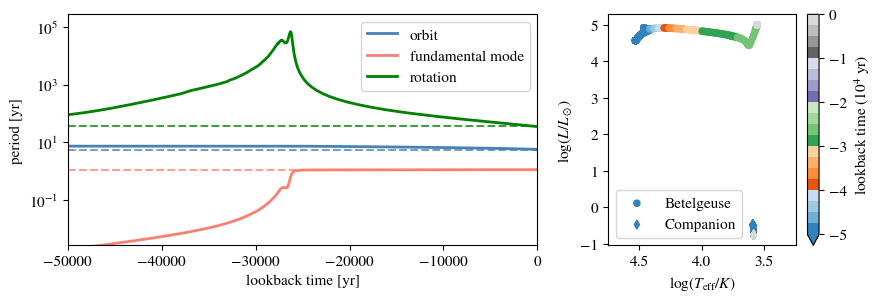

In [841]:
mesa_dir = "mesa_binary_model/"

bh=Table.read(mesa_dir+"LOGS1/history.data",header_start=4,format='ascii')
bh2=Table.read(mesa_dir+"LOGS2/history.data",header_start=4,format='ascii')
bh['tlb'] = bh['age']-bh['age'][-1]
bh2['tlb'] = bh2['age']-bh2['age'][-1]

print("STAR/BINARY HISTORY:")
print( bh.keys() )


#plt.subplots(figsize=(180*fig_mm,120*fig_mm),nrows=1,ncols=1,sharex=True,
#            gridspec_kw={'height_ratios': [2, 1]})
plt.subplots(figsize=(10,3),nrows=1,ncols=2,gridspec_kw={'width_ratios': [2, 1]})
plt.subplots_adjust(hspace=0.05)


plt.subplot(121)
# Orbit
ocolor = 'SteelBlue'
plt.plot(bh['tlb'],bh['period_days']/365.25,label='orbit',color=ocolor,lw=2)
plt.axhline(5.455,ls='--',color=ocolor,alpha=0.75)

# fundamental mode
fmcolor='Salmon'
plt.plot(bh['tlb'],2*np.pi/1.46/c.yr*np.sqrt((bh['star_1_radius']*c.rsun)**3/(c.G*bh['star_1_mass']*c.msun)),
        label='fundamental mode',color=fmcolor,lw=2)
plt.axhline(416./365.25,ls='--',color=fmcolor,alpha=0.75)

# rotation
rotcolor='green'
plt.plot(bh['tlb'],bh['period_days']*bh['P_rot_div_P_orb_1']/365.25,color=rotcolor,label='rotation',lw=2)
plt.axhline(36,ls='--',color=rotcolor,alpha=0.75)

plt.legend()
plt.semilogy()
plt.xlim(-5e4,0)
plt.ylim(1./365.25,1e8/365.25)
plt.xlabel('lookback time [yr]')
plt.ylabel('period [yr]')


plt.subplot(122)
mycm = 'tab20c'
plt.scatter(bh['log_Teff'],bh['log_L'],c=bh['tlb']/1e4,cmap=mycm,s=20,vmin=-5,vmax=0,label='Betelgeuse')
plt.scatter(bh2['log_Teff'],bh2['log_L'],c=bh2['tlb']/1e4,cmap=mycm,s=20,vmin=-5,vmax=0,marker='d',label='Companion')
plt.legend(loc='lower left')
plt.xlim(4.75,3.25)
plt.xlabel(r"$\log(T_{\rm eff}/K)$")
plt.ylabel(r"$\log(L/L_\odot)$")
plt.colorbar(label=r'lookback time ($10^4$ yr)',extend='min')
plt.savefig('figs/mesa_combined.pdf',bbox_inches='tight')



print("P [d]               Pspin [yr]            Pfm [d]")
print(bh['period_days'][-1],
      (bh['period_days']*bh['P_rot_div_P_orb_1']/365.25)[-1],
      2*np.pi/1.46/86400*np.sqrt((bh['star_1_radius']*c.rsun)**3/(c.G*bh['star_1_mass']*c.msun))[-1])

print("Teff [K]            L/1e5 [Lsun]")
print(10**bh['log_Teff'][-1], 10**bh['log_L'][-1]/1e5)

In [849]:
bh['star_1_mass'][-1]

18.382422830640362

In [846]:
# Moment of inertia
p=Table.read(mesa_dir+"LOGS1/profile4.data",header_start=4,format='ascii')

2/3 * np.sum((p['radius']*c.rsun)**2 * p['dm'])  / (p['mass'][0]*c.msun * (p['radius'][0]*c.rsun)**2 )

0.11297486969494579

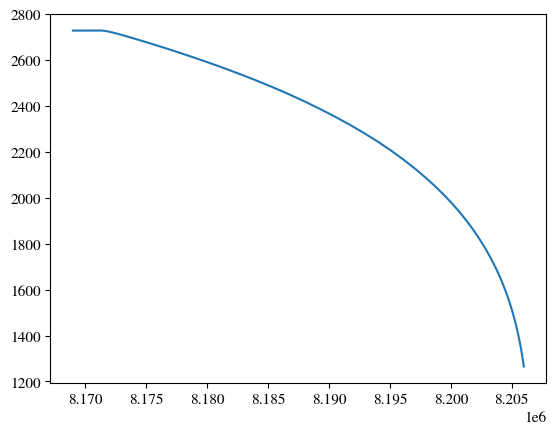

In [858]:
fut = Table.read("/Users/morganmacleod/DATA/mesaruns/BetelgeuseBinary/red/LOGS1/history.data",header_start=4,format='ascii')

plt.plot(fut['star_age'][-100:,],fut['period_days'][-100:,])

In [859]:
fut['star_age'][-1]  - bh['star_age'][-1]

8534.102508975193

In [576]:
10**5.2/10**4.6

3.9810717055349776

8544.60059040133

In [660]:
10**bh2['log_Teff'][-1]

3853.1699721933605

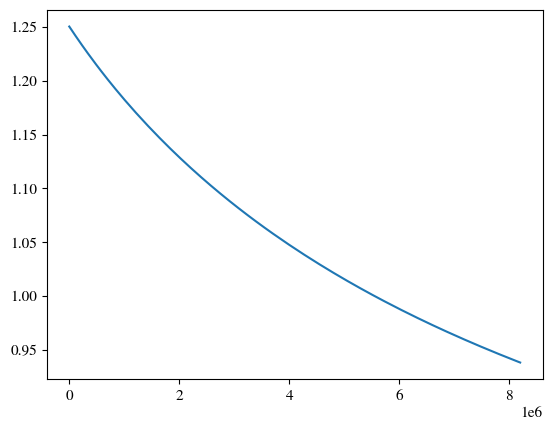

In [664]:
plt.plot(bh2['star_age'],10**bh2['log_R'])

In [674]:
10**bh['log_R'] / bh['binary_separation'] 

<Column name='log_R' dtype='float64' length=353>
0.0025648748581160227
 0.002564893645292771
0.0025649129261855084
 0.002564937194951447
0.0025649654243234924
0.0025649986564800146
 0.002565037841527698
0.0025650840927322486
 0.002565138700620599
 0.002565203135622426
0.0025652790578208485
 0.002565368321854626
 0.002565472987121842
0.0025655953915909406
0.0025657390333309327
 0.002565909320120139
0.0025661037850822125
 0.002566323608615619
                  ...
   0.3747826219226083
  0.37777998357397585
  0.38089797849234885
   0.3842812729948005
  0.38800903878740467
   0.3916018867944693
  0.39540120965589387
  0.39951089472768103
   0.4038395467972172
  0.40859513802141684
  0.41390958702421615
  0.41922385982969174
  0.42439955581501865
  0.42952482124251073
   0.4308231874021276
   0.4314982557892922
   0.4318214543134309
  0.43190342364962736

In [675]:
2000 * 10 / (2*np.pi*2000)

1.5915494309189535

In [883]:
8.5*c.au/(175*c.pc) / 4.8481368E-9

48.572120031333434

In [682]:
(c.rsun/(185*c.pc) / 4.8481368E-9 /20)**2

1.578846826663224e-06

In [878]:
2.73/np.sqrt(c.G*12*c.msun/(7*c.au)) * 1.e5 * 12

0.8399580451014896

In [882]:
43.1*(18/17.5)**(1/3)

43.50662778803573